<a href="https://colab.research.google.com/github/Trung0Minh/AIO2023-MODULE-7/blob/main/domain_conversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNet Model

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
from PIL import Image
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
!pip install torcheval
from torcheval.metrics.functional import peak_signal_noise_ratio
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(66)

In [ ]:
LHR_TRAIN_DATA_PATH = '/content/Khoa_LHR_image/train'
LHR_VAL_DATA_PATH = '/content/Khoa_LHR_image/val'
BATCH_SIZE = 8
LOW_IMG_HEIGHT = 64
LOW_IMG_WIDTH = 64

## No skip connection

In [ ]:
class FirstFeatureNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FirstFeatureNoSkip, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)


class ConvBlockNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlockNoSkip, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class EncoderNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(EncoderNoSkip, self).__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlockNoSkip(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


class DecoderNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderNoSkip, self).__init__()
        self.conv = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels*2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_channels*2),
            nn.LeakyReLU(),
        )
        self.conv_block = ConvBlockNoSkip(out_channels*2, out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.conv_block(x)
        return x


class FinalOutputNoSkip(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FinalOutputNoSkip, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv(x)


class SR_Unet_NoSkip(nn.Module):
    def __init__(
            self, n_channels=3, n_classes=3
    ):
        super(SR_Unet_NoSkip, self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.resize_fnc = transforms.Resize((LOW_IMG_HEIGHT*4, LOW_IMG_HEIGHT*4),
                                             antialias=True)
        self.in_conv1 = FirstFeatureNoSkip(n_channels, 64)
        self.in_conv2 = ConvBlockNoSkip(64, 64)

        self.enc_1 = EncoderNoSkip(64, 128)
        self.enc_2 = EncoderNoSkip(128, 256)
        self.enc_3 = EncoderNoSkip(256, 512)
        self.enc_4 = EncoderNoSkip(512, 1024)

        self.dec_1 = DecoderNoSkip(1024, 512)
        self.dec_2 = DecoderNoSkip(512, 256)
        self.dec_3 = DecoderNoSkip(256, 128)
        self.dec_4 = DecoderNoSkip(128, 64)

        self.out_conv = FinalOutputNoSkip(64, n_classes)


    def forward(self, x):
        x = self.resize_fnc(x)
        x = self.in_conv1(x)
        x = self.in_conv2(x)

        x = self.enc_1(x)
        x = self.enc_2(x)
        x = self.enc_3(x)
        x = self.enc_4(x)

        x = self.dec_1(x)
        x = self.dec_2(x)
        x = self.dec_3(x)
        x = self.dec_4(x)

        x = self.out_conv(x)
        return x

In [ ]:
unet_model = SR_Unet_NoSkip().to(device)
img = torch.ones(2, 3, 64, 64).to(device)
unet_model(img).shape

torch.Size([2, 3, 256, 256])

## With skip connection

In [ ]:
class FirstFeature(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.conv(x)
        x = torch.concat([x, skip], dim=1)
        x = self.conv_block(x)
        return x

class FinalOutput(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv(x)

class SR_Unet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.resize_fnc = transforms.Resize((LOW_IMG_HEIGHT*4, LOW_IMG_HEIGHT*4),
                                             antialias=True)

        self.in_conv1 = FirstFeature(n_channels, 64)
        self.in_conv2 = ConvBlock(64, 64)

        self.enc_1 = Encoder(64, 128)
        self.enc_2 = Encoder(128, 256)
        self.enc_3 = Encoder(256, 512)
        self.enc_4 = Encoder(512, 1024)

        self.dec_1 = Decoder(1024, 512)
        self.dec_2 = Decoder(512, 256)
        self.dec_3 = Decoder(256, 128)
        self.dec_4 = Decoder(128, 64)

        self.out_conv = FinalOutput(64, n_classes)

    def forward(self, x):
        x = self.resize_fnc(x)
        x = self.in_conv1(x)
        x1 = self.in_conv2(x)

        x2 = self.enc_1(x1)
        x3 = self.enc_2(x2)
        x4 = self.enc_3(x3)
        x5 = self.enc_4(x4)

        x = self.dec_1(x5, x4)
        x = self.dec_2(x, x3)
        x = self.dec_3(x, x2)
        x = self.dec_4(x, x1)

        x = self.out_conv(x)
        return x

In [ ]:
unet_model = SR_Unet()
img = torch.ones(2, 3, 64, 64)
unet_model(img).shape

torch.Size([2, 3, 256, 256])

# Super Resolution with UNet

## Download dataset

In [ ]:
!gdown --id 1qTkTp1OfumLB2dHtX6e_c2lhNNcnOZOx

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1qTkTp1OfumLB2dHtX6e_c2lhNNcnOZOx
From (redirected): https://drive.google.com/uc?id=1qTkTp1OfumLB2dHtX6e_c2lhNNcnOZOx&confirm=t&uuid=34bac0d9-eed4-48bc-93ef-ddd18c0a8234
To: /content/Khoa_LHR_image.zip
100% 89.0M/89.0M [00:00<00:00, 186MB/s]


In [ ]:
!unzip /content/Khoa_LHR_image.zip

## Prepare dataset

### Split train-test data

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, is_train=True):
        self.resize = transforms.Resize((LOW_IMG_WIDTH, LOW_IMG_HEIGHT), antialias=True)
        self.is_train = is_train
        self.img_dir = img_dir
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def normalize(self, input_image, target_image):
        input_image = input_image*2 - 1
        target_image = target_image*2 - 1

        return input_image, target_image

    def random_jitter(self, input_image, target_image):
        if torch.rand([]) < 0.5:
            input_image = transforms.functional.hflip(input_image)
            target_image = transforms.functional.hflip(target_image)

        return input_image, target_image

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        img = np.array(Image.open(img_path).convert('RGB'))
        img = transforms.functional.to_tensor(img)

        input_image = self.resize(img).type(torch.float32)
        target_image = img.type(torch.float32)

        input_image, target_image = self.normalize(input_image, target_image)
        if self.is_train:
            input_image, target_image = self.random_jitter(input_image, target_image)

        return input_image, target_image

In [ ]:
train_dataset = ImageDataset(LHR_TRAIN_DATA_PATH, is_train=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = ImageDataset(LHR_VAL_DATA_PATH, is_train=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
inputs, labels = next(iter(train_loader))
inputs.shape, labels.shape

(torch.Size([8, 3, 64, 64]), torch.Size([8, 3, 256, 256]))

Text(0.5, 1.0, 'Target')

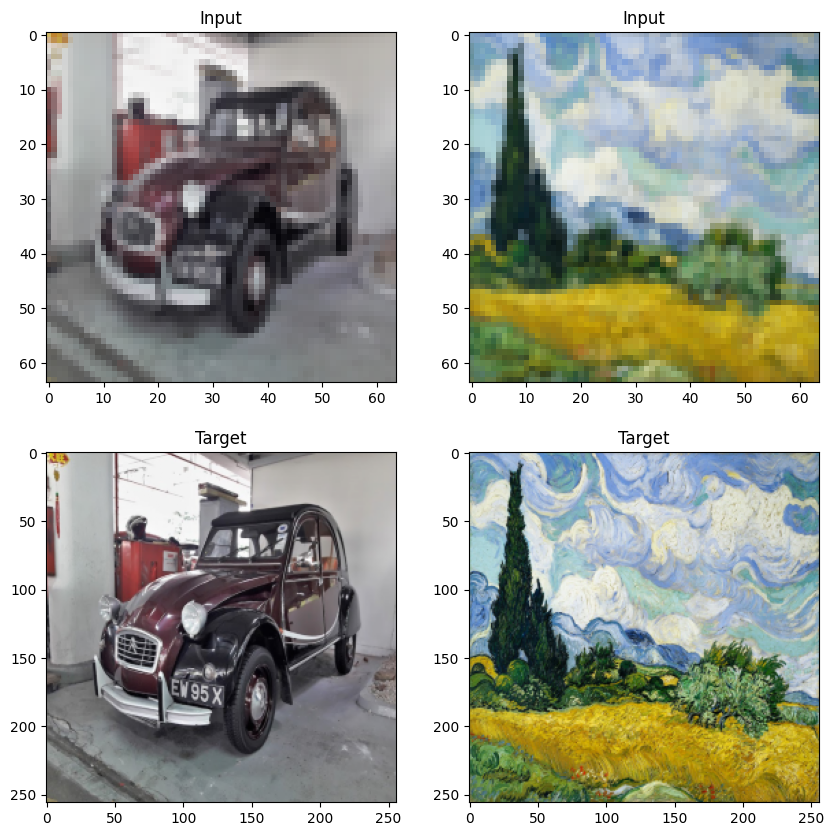

In [ ]:
in_batch, tar_batch = next(iter(train_loader))
in_batch = (in_batch + 1)/2
tar_batch = (tar_batch + 1)/2

plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plt.imshow(np.squeeze(in_batch[0].numpy().transpose((1, 2, 0))))
plt.title("Input")
ax = plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(tar_batch[0].numpy().transpose((1, 2, 0))))
plt.title("Target")
ax = plt.subplot(2, 2, 2)
plt.imshow(np.squeeze(in_batch[1].numpy().transpose((1, 2, 0))))
plt.title("Input")
ax = plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(tar_batch[1].numpy().transpose((1, 2, 0))))
plt.title("Target")

In [ ]:
def generate_images(model, inputs, labels):
    model.eval()
    with torch.no_grad():
        inputs, labels = inputs.to(device), labels.to(device)
        preds = model(inputs)
    inputs, labels, predictions = inputs.cpu().numpy(), labels.cpu().numpy(), preds.cpu().numpy()
    plt.figure(figsize=(15, 20))

    display_list = [inputs[-1].transpose((1, 2, 0)), labels[-1].transpose((1, 2, 0)), predictions[-1].transpose((1, 2, 0))]
    title = ['Input', 'Real', 'Predicted']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

In [ ]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch, log_interval=50):
    model.train()
    total_psnr, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        total_psnr += peak_signal_noise_ratio(preds, labels)
        total_count += 1

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| Epoch {:3d} | {:5d}/{:5d} batches "
                "| Psnr {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_psnr / total_count
                )
            )
            total_psnr, total_count = 0, 0
            start_time = time.time()

    epoch_psnr = total_psnr / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_psnr, epoch_loss

In [ ]:
def evaluate_epoch(model, criterion, val_dataloader, device):
    model.eval()
    total_psnr, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(val_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs)
            loss = criterion(preds, labels)
            losses.append(loss.item())

            total_psnr += peak_signal_noise_ratio(preds, labels)
            total_count += 1

    epoch_psnr = total_psnr / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_psnr, epoch_loss

In [ ]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader,
          val_dataloader, num_epochs, device):
    train_psnrs, train_losses = [], []
    eval_psnrs, eval_losses = [], []
    best_psnr_eval = -1000
    times = []

    for epoch in range(1, num_epochs + 1):
        epoch_start_time = time.time()

        train_psnr, train_loss = train_epoch(
            model, optimizer, criterion, train_dataloader, device, epoch
        )
        train_psnrs.append(train_psnr)
        train_losses.append(train_loss)

        eval_psnr, eval_loss = evaluate_epoch(
            model, criterion, val_dataloader, device
        )
        eval_psnrs.append(eval_psnr)
        eval_losses.append(eval_loss)

        if eval_psnr > best_psnr_eval:
            torch.save(model.state_dict(), save_model + f"/{model_name}.pt")
            inputs_t, targets_t = next(iter(val_dataloader))
            generate_images(model, inputs_t, targets_t)
            best_psnr_eval = eval_psnr
        times.append(time.time() - epoch_start_time)

        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train psnr {:8.3f} | Train Loss {:8.3f} "
            "| Valid psnr {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_psnr, train_loss, eval_psnr, eval_loss
            )
        )
        print("-" * 59)

    model.load_state_dict(torch.load(save_model + f"/{model_name}.pt"))
    model.eval()
    metrics = {
        'train_psnr': train_psnrs,
        'train_loss': train_losses,
        'valid_psnr': eval_psnrs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [ ]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_psnrs, eval_psnrs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_psnrs, label = "Training")
    axs[0].plot(epochs, eval_psnrs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("PSNR")
    axs[1].set_ylabel("Loss")
    plt.legend()

In [ ]:
def predict_and_display(model, test_dataloader, device):
    model.eval()
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_dataloader):
            if idx >= 10:
                break
            inputs = inputs.to(device)
            predictions = model(inputs)
            generate_images(model, inputs, labels)
            plt.show()

### UNet no skip connection

| Epoch   1 |    50/   86 batches | Psnr   14.855


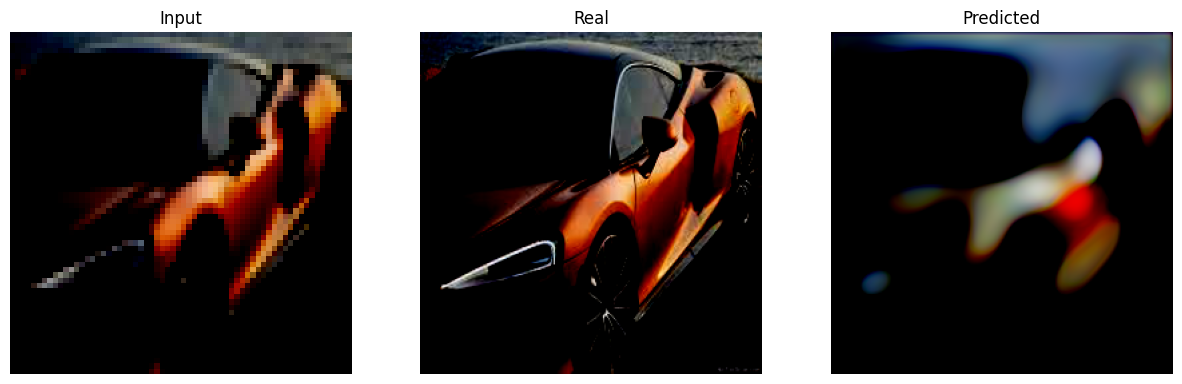

-----------------------------------------------------------
| End of epoch   1 | Time: 54.58s | Train psnr   16.084 | Train Loss    0.253 | Valid psnr   16.265 | Valid Loss    0.206 
-----------------------------------------------------------
| Epoch   2 |    50/   86 batches | Psnr   15.831


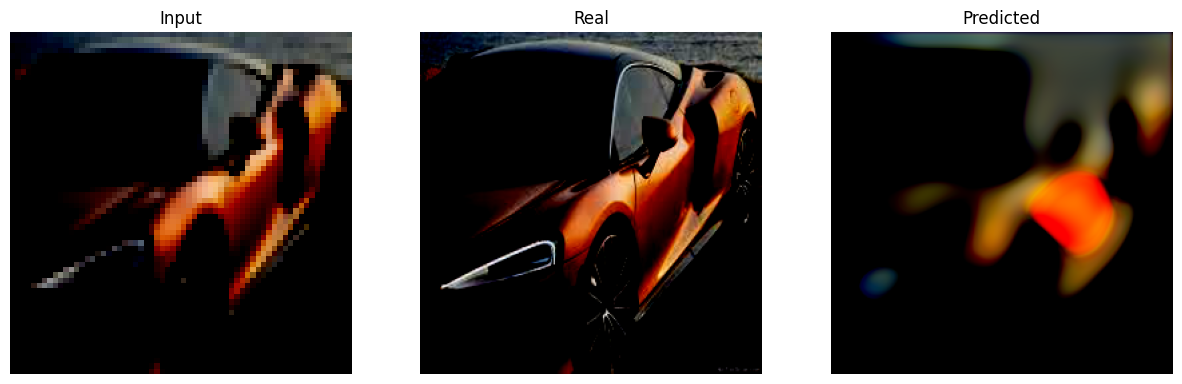

-----------------------------------------------------------
| End of epoch   2 | Time: 55.45s | Train psnr   16.607 | Train Loss    0.222 | Valid psnr   16.670 | Valid Loss    0.205 
-----------------------------------------------------------
| Epoch   3 |    50/   86 batches | Psnr   16.686


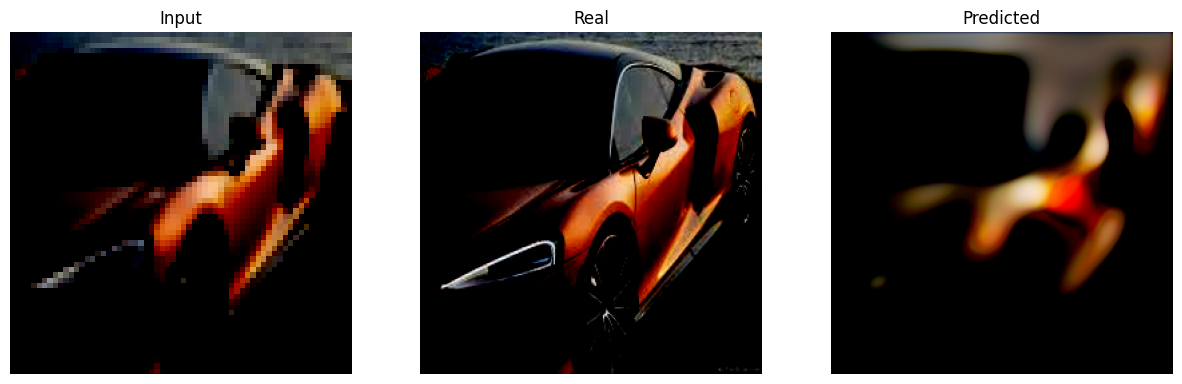

-----------------------------------------------------------
| End of epoch   3 | Time: 55.13s | Train psnr   17.102 | Train Loss    0.200 | Valid psnr   17.448 | Valid Loss    0.181 
-----------------------------------------------------------
| Epoch   4 |    50/   86 batches | Psnr   17.338
-----------------------------------------------------------
| End of epoch   4 | Time: 54.25s | Train psnr   16.606 | Train Loss    0.196 | Valid psnr   17.080 | Valid Loss    0.200 
-----------------------------------------------------------
| Epoch   5 |    50/   86 batches | Psnr   17.038


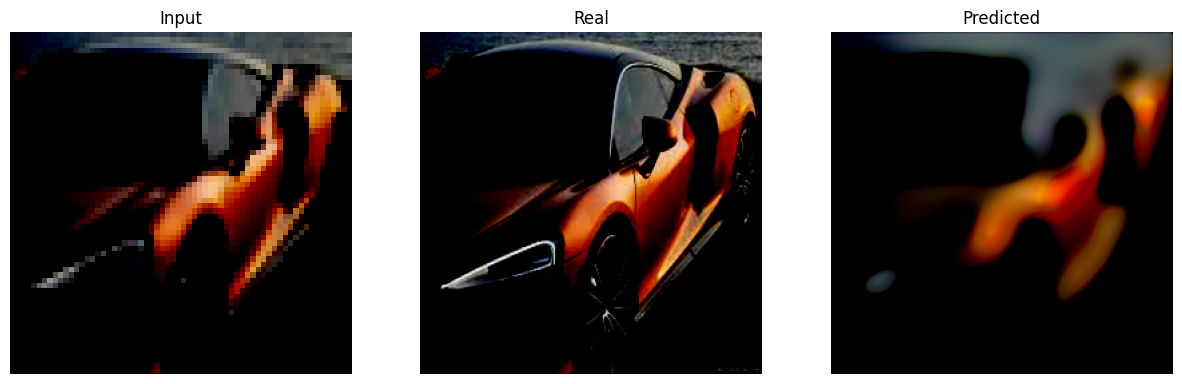

-----------------------------------------------------------
| End of epoch   5 | Time: 54.98s | Train psnr   17.183 | Train Loss    0.194 | Valid psnr   17.839 | Valid Loss    0.168 
-----------------------------------------------------------
| Epoch   6 |    50/   86 batches | Psnr   17.496


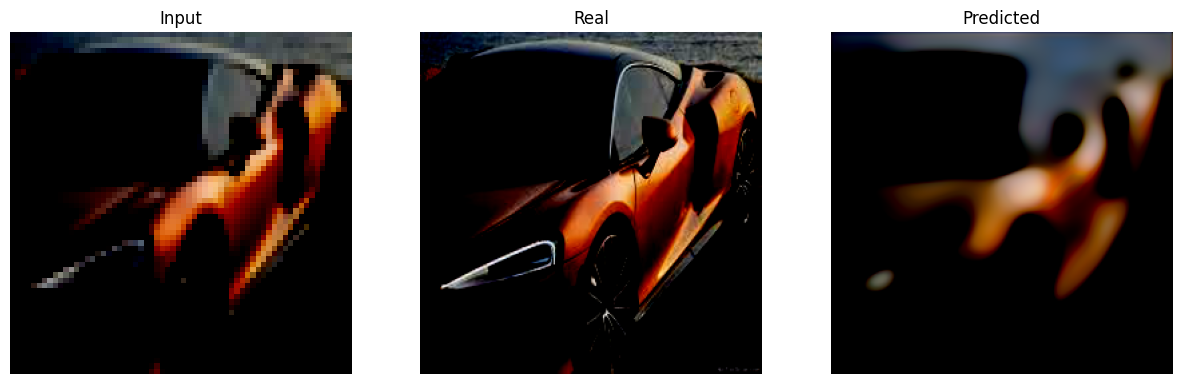

-----------------------------------------------------------
| End of epoch   6 | Time: 55.17s | Train psnr   17.589 | Train Loss    0.183 | Valid psnr   18.006 | Valid Loss    0.166 
-----------------------------------------------------------
| Epoch   7 |    50/   86 batches | Psnr   17.668


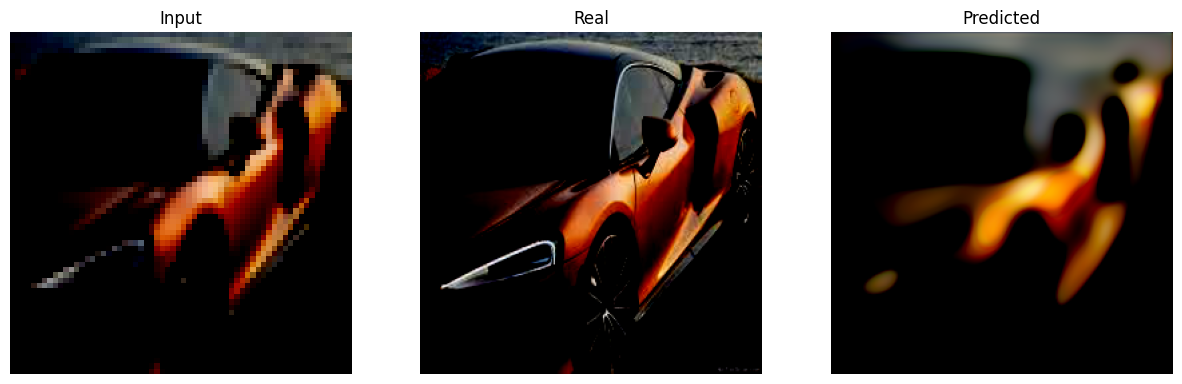

-----------------------------------------------------------
| End of epoch   7 | Time: 55.24s | Train psnr   17.922 | Train Loss    0.175 | Valid psnr   18.035 | Valid Loss    0.167 
-----------------------------------------------------------
| Epoch   8 |    50/   86 batches | Psnr   17.550
-----------------------------------------------------------
| End of epoch   8 | Time: 54.29s | Train psnr   18.164 | Train Loss    0.176 | Valid psnr   17.333 | Valid Loss    0.179 
-----------------------------------------------------------
| Epoch   9 |    50/   86 batches | Psnr   18.096


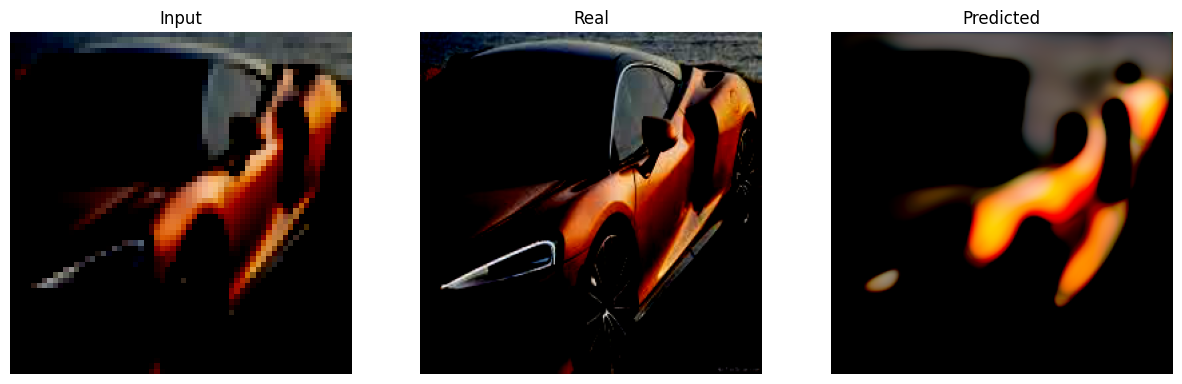

-----------------------------------------------------------
| End of epoch   9 | Time: 54.90s | Train psnr   18.191 | Train Loss    0.169 | Valid psnr   18.263 | Valid Loss    0.166 
-----------------------------------------------------------
| Epoch  10 |    50/   86 batches | Psnr   18.261


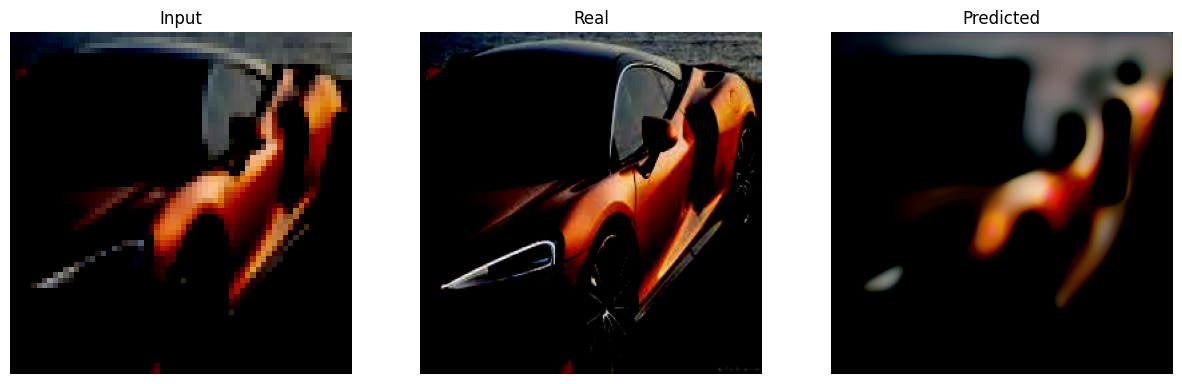

-----------------------------------------------------------
| End of epoch  10 | Time: 54.92s | Train psnr   18.336 | Train Loss    0.164 | Valid psnr   18.710 | Valid Loss    0.154 
-----------------------------------------------------------
| Epoch  11 |    50/   86 batches | Psnr   18.694
-----------------------------------------------------------
| End of epoch  11 | Time: 54.41s | Train psnr   18.377 | Train Loss    0.158 | Valid psnr   18.176 | Valid Loss    0.156 
-----------------------------------------------------------
| Epoch  12 |    50/   86 batches | Psnr   18.541
-----------------------------------------------------------
| End of epoch  12 | Time: 54.27s | Train psnr   18.546 | Train Loss    0.159 | Valid psnr   17.570 | Valid Loss    0.175 
-----------------------------------------------------------
| Epoch  13 |    50/   86 batches | Psnr   17.361


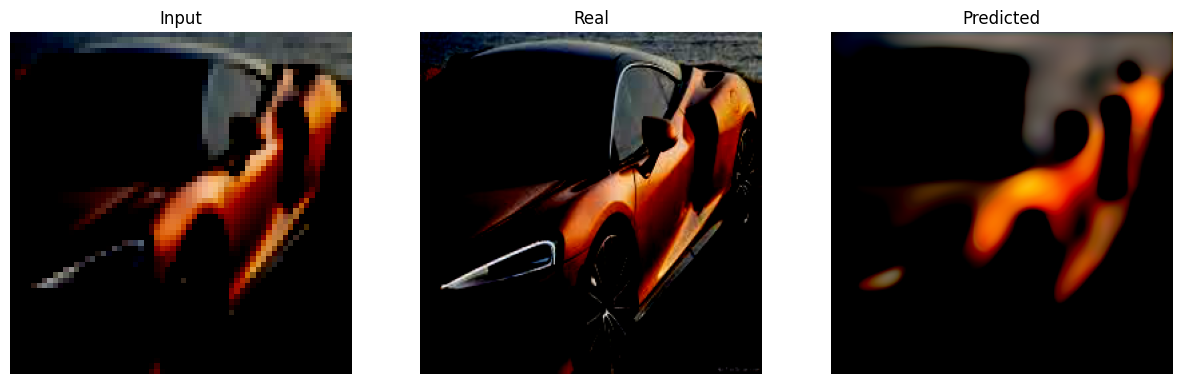

-----------------------------------------------------------
| End of epoch  13 | Time: 54.84s | Train psnr   18.043 | Train Loss    0.178 | Valid psnr   18.759 | Valid Loss    0.155 
-----------------------------------------------------------
| Epoch  14 |    50/   86 batches | Psnr   18.611


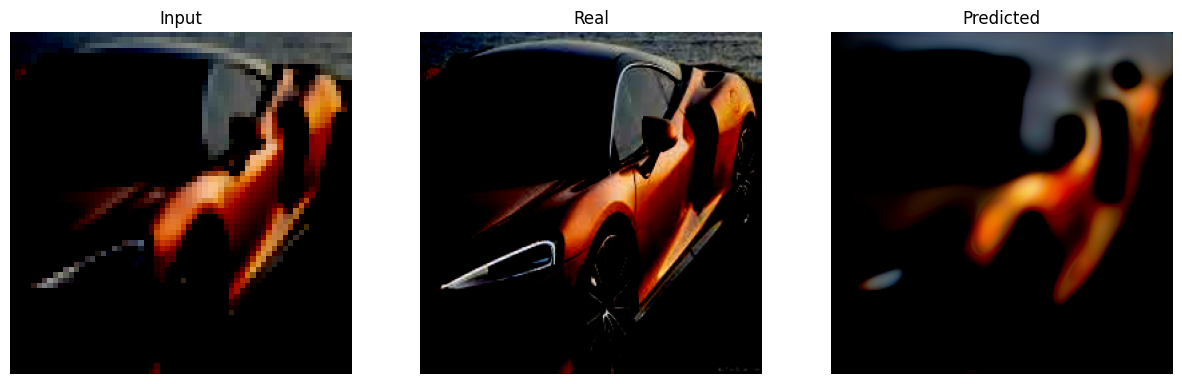

-----------------------------------------------------------
| End of epoch  14 | Time: 54.91s | Train psnr   18.546 | Train Loss    0.157 | Valid psnr   19.095 | Valid Loss    0.148 
-----------------------------------------------------------
| Epoch  15 |    50/   86 batches | Psnr   18.838
-----------------------------------------------------------
| End of epoch  15 | Time: 54.29s | Train psnr   18.752 | Train Loss    0.152 | Valid psnr   18.985 | Valid Loss    0.144 
-----------------------------------------------------------
| Epoch  16 |    50/   86 batches | Psnr   19.007
-----------------------------------------------------------
| End of epoch  16 | Time: 54.40s | Train psnr   19.002 | Train Loss    0.149 | Valid psnr   18.817 | Valid Loss    0.158 
-----------------------------------------------------------
| Epoch  17 |    50/   86 batches | Psnr   19.007
-----------------------------------------------------------
| End of epoch  17 | Time: 54.28s | Train psnr   19.004 | Tra

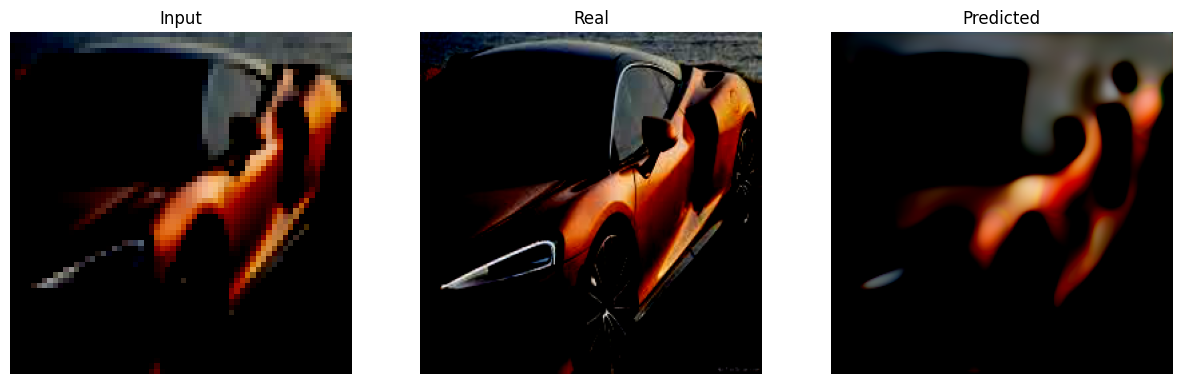

-----------------------------------------------------------
| End of epoch  19 | Time: 54.89s | Train psnr   19.527 | Train Loss    0.144 | Valid psnr   19.268 | Valid Loss    0.139 
-----------------------------------------------------------
| Epoch  20 |    50/   86 batches | Psnr   19.219
-----------------------------------------------------------
| End of epoch  20 | Time: 54.35s | Train psnr   19.559 | Train Loss    0.142 | Valid psnr   18.703 | Valid Loss    0.154 
-----------------------------------------------------------
| Epoch  21 |    50/   86 batches | Psnr   19.354


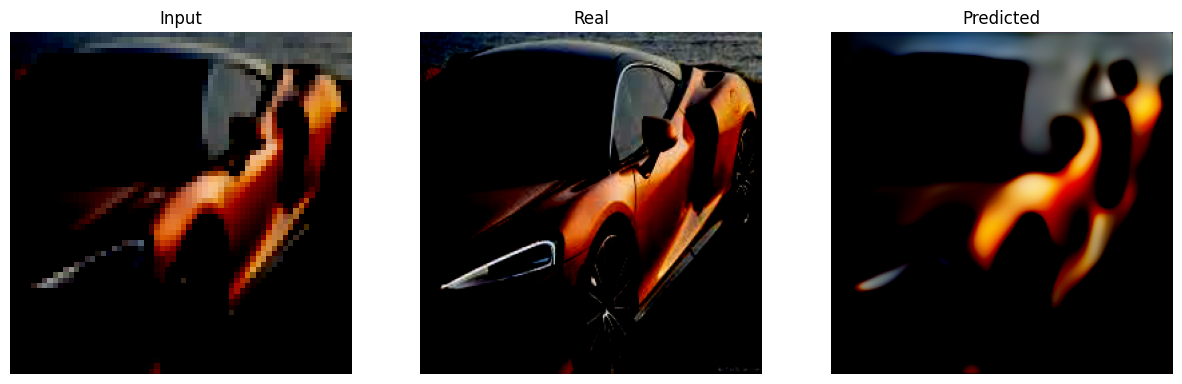

-----------------------------------------------------------
| End of epoch  21 | Time: 55.12s | Train psnr   19.623 | Train Loss    0.140 | Valid psnr   19.479 | Valid Loss    0.137 
-----------------------------------------------------------
| Epoch  22 |    50/   86 batches | Psnr   19.554
-----------------------------------------------------------
| End of epoch  22 | Time: 54.37s | Train psnr   19.502 | Train Loss    0.139 | Valid psnr   15.539 | Valid Loss    0.220 
-----------------------------------------------------------
| Epoch  23 |    50/   86 batches | Psnr   19.314
-----------------------------------------------------------
| End of epoch  23 | Time: 54.13s | Train psnr   19.457 | Train Loss    0.143 | Valid psnr   16.203 | Valid Loss    0.216 
-----------------------------------------------------------
| Epoch  24 |    50/   86 batches | Psnr   19.496
-----------------------------------------------------------
| End of epoch  24 | Time: 54.22s | Train psnr   19.629 | Tra

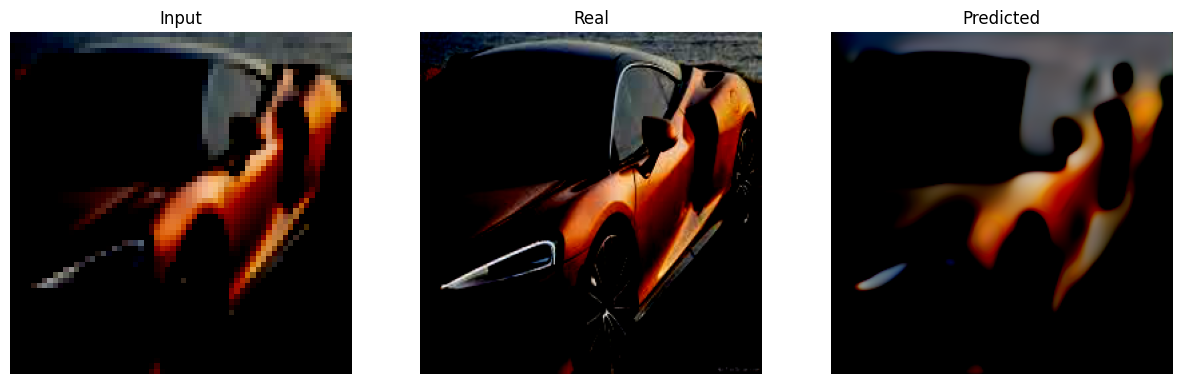

-----------------------------------------------------------
| End of epoch  26 | Time: 55.14s | Train psnr   19.976 | Train Loss    0.135 | Valid psnr   19.995 | Valid Loss    0.130 
-----------------------------------------------------------
| Epoch  27 |    50/   86 batches | Psnr   20.092


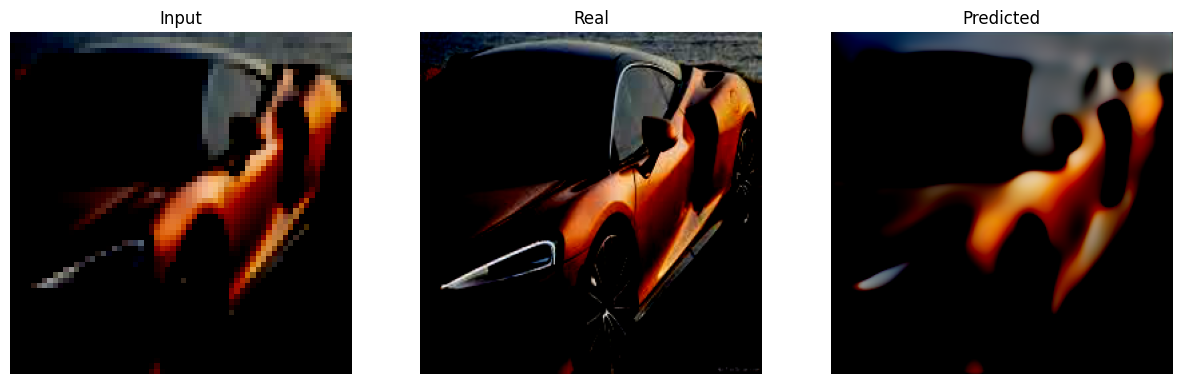

-----------------------------------------------------------
| End of epoch  27 | Time: 54.95s | Train psnr   19.738 | Train Loss    0.132 | Valid psnr   20.106 | Valid Loss    0.126 
-----------------------------------------------------------
| Epoch  28 |    50/   86 batches | Psnr   18.264
-----------------------------------------------------------
| End of epoch  28 | Time: 54.27s | Train psnr   17.774 | Train Loss    0.171 | Valid psnr   19.016 | Valid Loss    0.153 
-----------------------------------------------------------
| Epoch  29 |    50/   86 batches | Psnr   19.228
-----------------------------------------------------------
| End of epoch  29 | Time: 54.25s | Train psnr   19.670 | Train Loss    0.143 | Valid psnr   19.813 | Valid Loss    0.131 
-----------------------------------------------------------
| Epoch  30 |    50/   86 batches | Psnr   19.758
-----------------------------------------------------------
| End of epoch  30 | Time: 54.45s | Train psnr   19.867 | Tra

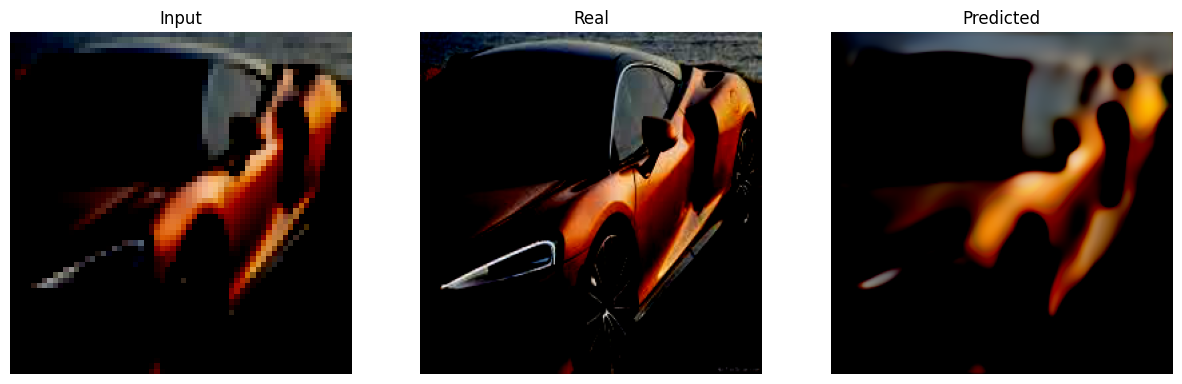

-----------------------------------------------------------
| End of epoch  33 | Time: 55.06s | Train psnr   20.251 | Train Loss    0.127 | Valid psnr   20.187 | Valid Loss    0.128 
-----------------------------------------------------------
| Epoch  34 |    50/   86 batches | Psnr   20.289


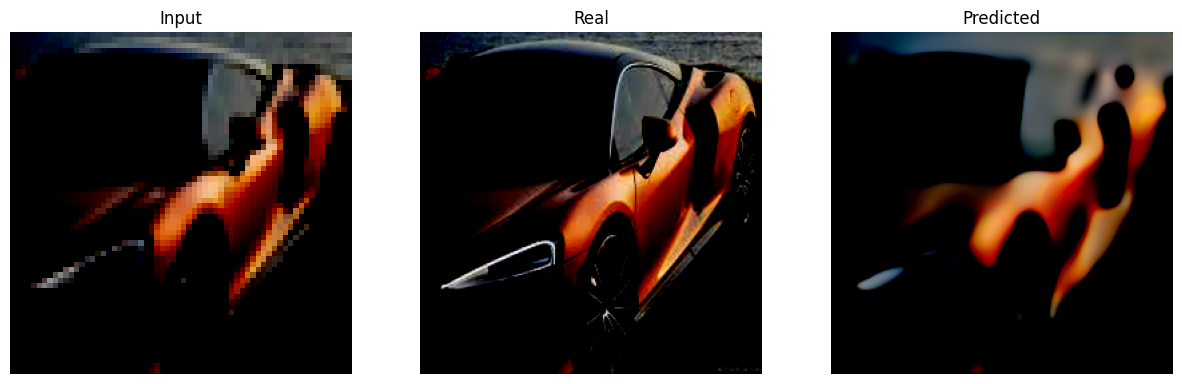

-----------------------------------------------------------
| End of epoch  34 | Time: 55.09s | Train psnr   20.188 | Train Loss    0.127 | Valid psnr   20.304 | Valid Loss    0.126 
-----------------------------------------------------------
| Epoch  35 |    50/   86 batches | Psnr   20.090
-----------------------------------------------------------
| End of epoch  35 | Time: 54.47s | Train psnr   20.497 | Train Loss    0.127 | Valid psnr   20.216 | Valid Loss    0.130 
-----------------------------------------------------------
| Epoch  36 |    50/   86 batches | Psnr   20.346
-----------------------------------------------------------
| End of epoch  36 | Time: 54.31s | Train psnr   20.334 | Train Loss    0.125 | Valid psnr   20.208 | Valid Loss    0.124 
-----------------------------------------------------------
| Epoch  37 |    50/   86 batches | Psnr   20.404
-----------------------------------------------------------
| End of epoch  37 | Time: 54.18s | Train psnr   20.241 | Tra

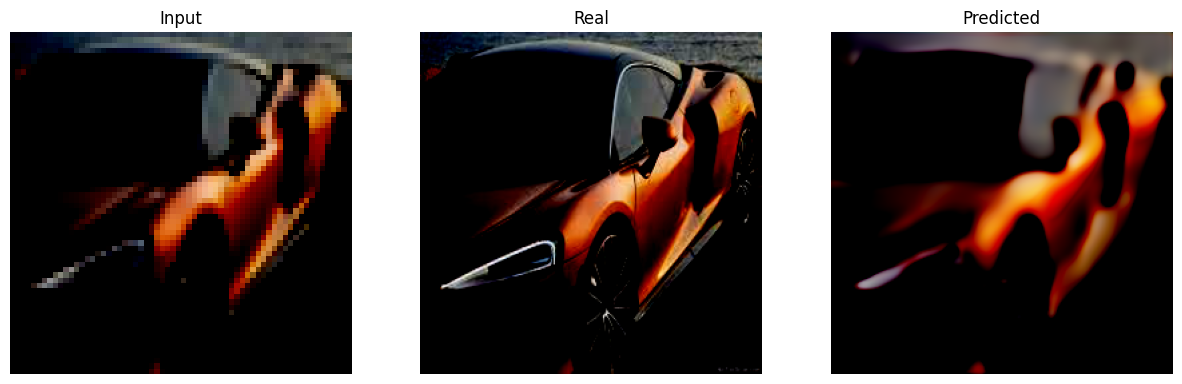

-----------------------------------------------------------
| End of epoch  42 | Time: 55.11s | Train psnr   20.564 | Train Loss    0.121 | Valid psnr   20.336 | Valid Loss    0.125 
-----------------------------------------------------------
| Epoch  43 |    50/   86 batches | Psnr   20.524
-----------------------------------------------------------
| End of epoch  43 | Time: 54.28s | Train psnr   20.630 | Train Loss    0.123 | Valid psnr   20.015 | Valid Loss    0.134 
-----------------------------------------------------------
| Epoch  44 |    50/   86 batches | Psnr   20.577
-----------------------------------------------------------
| End of epoch  44 | Time: 54.25s | Train psnr   20.736 | Train Loss    0.121 | Valid psnr   19.765 | Valid Loss    0.132 
-----------------------------------------------------------
| Epoch  45 |    50/   86 batches | Psnr   20.847


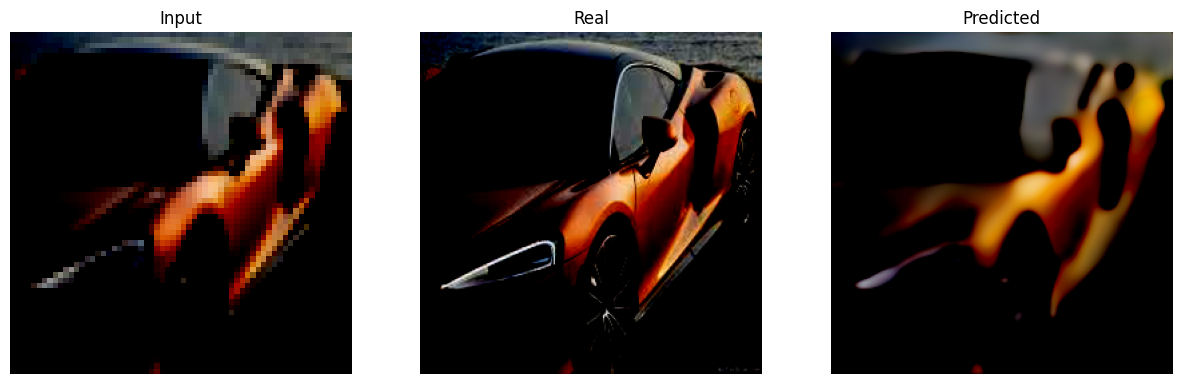

-----------------------------------------------------------
| End of epoch  45 | Time: 55.50s | Train psnr   20.521 | Train Loss    0.119 | Valid psnr   20.656 | Valid Loss    0.122 
-----------------------------------------------------------
| Epoch  46 |    50/   86 batches | Psnr   20.886


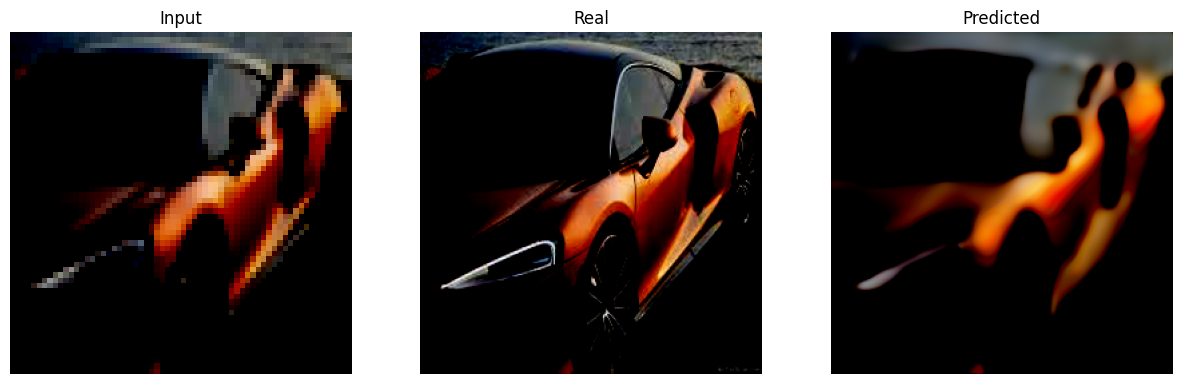

-----------------------------------------------------------
| End of epoch  46 | Time: 55.10s | Train psnr   20.644 | Train Loss    0.118 | Valid psnr   20.661 | Valid Loss    0.119 
-----------------------------------------------------------
| Epoch  47 |    50/   86 batches | Psnr   20.850
-----------------------------------------------------------
| End of epoch  47 | Time: 54.20s | Train psnr   20.679 | Train Loss    0.118 | Valid psnr   20.429 | Valid Loss    0.123 
-----------------------------------------------------------
| Epoch  48 |    50/   86 batches | Psnr   20.707
-----------------------------------------------------------
| End of epoch  48 | Time: 54.25s | Train psnr   20.595 | Train Loss    0.121 | Valid psnr   20.353 | Valid Loss    0.127 
-----------------------------------------------------------
| Epoch  49 |    50/   86 batches | Psnr   20.936
-----------------------------------------------------------
| End of epoch  49 | Time: 54.42s | Train psnr   20.593 | Tra

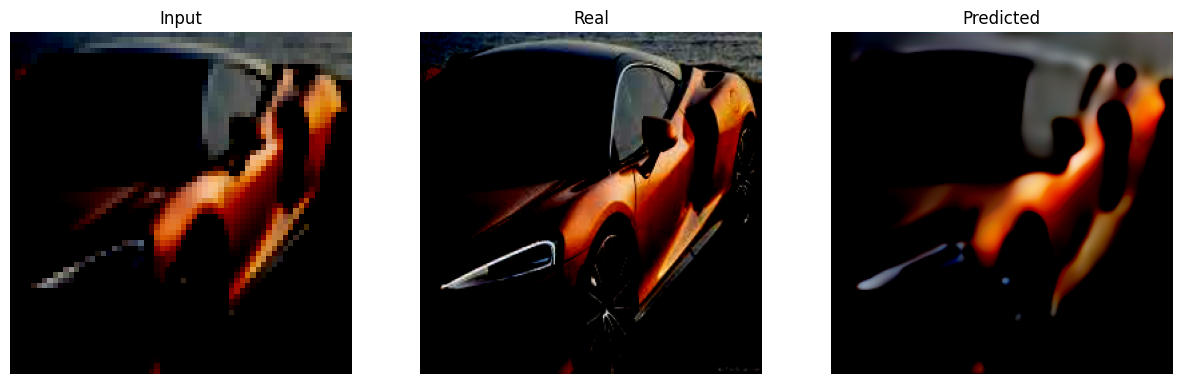

-----------------------------------------------------------
| End of epoch  52 | Time: 55.06s | Train psnr   21.155 | Train Loss    0.116 | Valid psnr   20.985 | Valid Loss    0.111 
-----------------------------------------------------------
| Epoch  53 |    50/   86 batches | Psnr   20.953
-----------------------------------------------------------
| End of epoch  53 | Time: 54.23s | Train psnr   21.071 | Train Loss    0.115 | Valid psnr   20.387 | Valid Loss    0.128 
-----------------------------------------------------------
| Epoch  54 |    50/   86 batches | Psnr   21.022
-----------------------------------------------------------
| End of epoch  54 | Time: 54.41s | Train psnr   21.010 | Train Loss    0.115 | Valid psnr   20.347 | Valid Loss    0.124 
-----------------------------------------------------------
| Epoch  55 |    50/   86 batches | Psnr   20.919
-----------------------------------------------------------
| End of epoch  55 | Time: 54.37s | Train psnr   21.142 | Tra

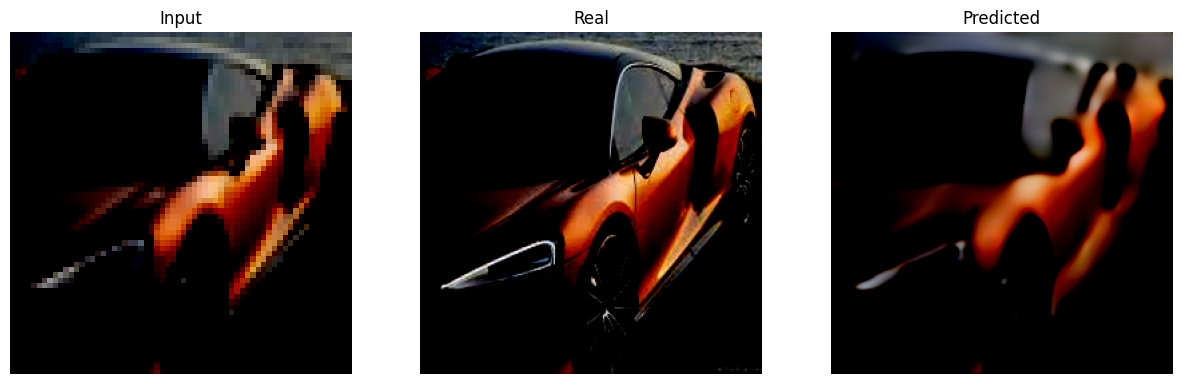

-----------------------------------------------------------
| End of epoch  57 | Time: 55.14s | Train psnr   20.990 | Train Loss    0.113 | Valid psnr   21.048 | Valid Loss    0.111 
-----------------------------------------------------------
| Epoch  58 |    50/   86 batches | Psnr   21.379
-----------------------------------------------------------
| End of epoch  58 | Time: 54.29s | Train psnr   21.244 | Train Loss    0.109 | Valid psnr   20.979 | Valid Loss    0.114 
-----------------------------------------------------------
| Epoch  59 |    50/   86 batches | Psnr   20.964
-----------------------------------------------------------
| End of epoch  59 | Time: 54.44s | Train psnr   21.387 | Train Loss    0.113 | Valid psnr   20.779 | Valid Loss    0.117 
-----------------------------------------------------------
| Epoch  60 |    50/   86 batches | Psnr   21.380
-----------------------------------------------------------
| End of epoch  60 | Time: 54.41s | Train psnr   21.133 | Tra

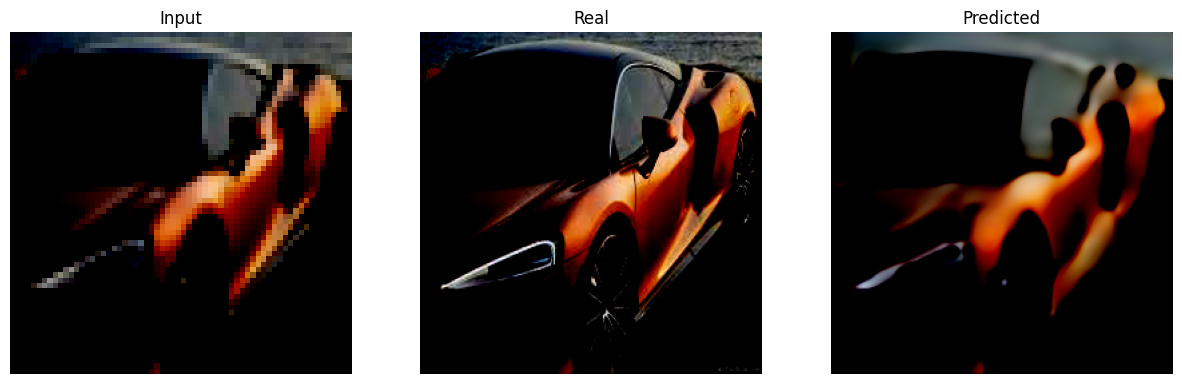

-----------------------------------------------------------
| End of epoch  67 | Time: 55.01s | Train psnr   21.404 | Train Loss    0.109 | Valid psnr   21.060 | Valid Loss    0.111 
-----------------------------------------------------------
| Epoch  68 |    50/   86 batches | Psnr   21.432


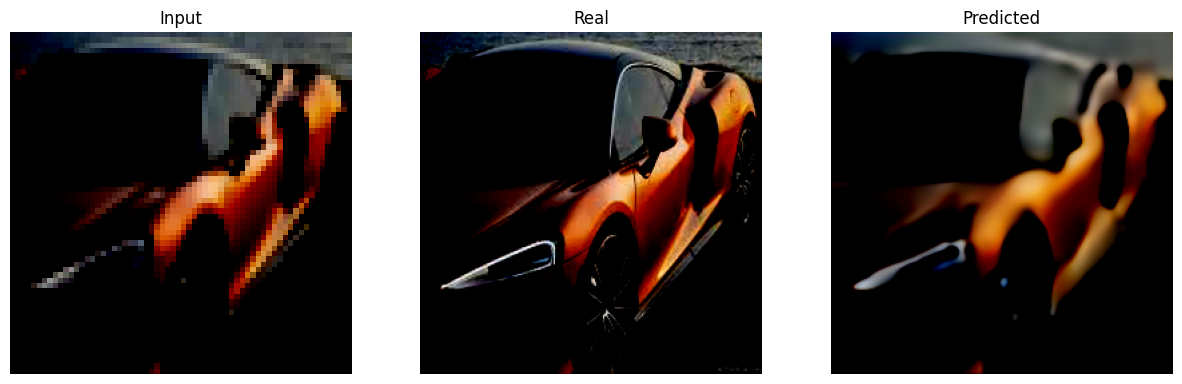

-----------------------------------------------------------
| End of epoch  68 | Time: 55.10s | Train psnr   21.419 | Train Loss    0.109 | Valid psnr   21.089 | Valid Loss    0.113 
-----------------------------------------------------------
| Epoch  69 |    50/   86 batches | Psnr   21.505
-----------------------------------------------------------
| End of epoch  69 | Time: 54.49s | Train psnr   21.345 | Train Loss    0.108 | Valid psnr   20.887 | Valid Loss    0.117 
-----------------------------------------------------------
| Epoch  70 |    50/   86 batches | Psnr   21.493
-----------------------------------------------------------
| End of epoch  70 | Time: 54.38s | Train psnr   21.646 | Train Loss    0.107 | Valid psnr   20.850 | Valid Loss    0.113 
-----------------------------------------------------------
| Epoch  71 |    50/   86 batches | Psnr   21.525


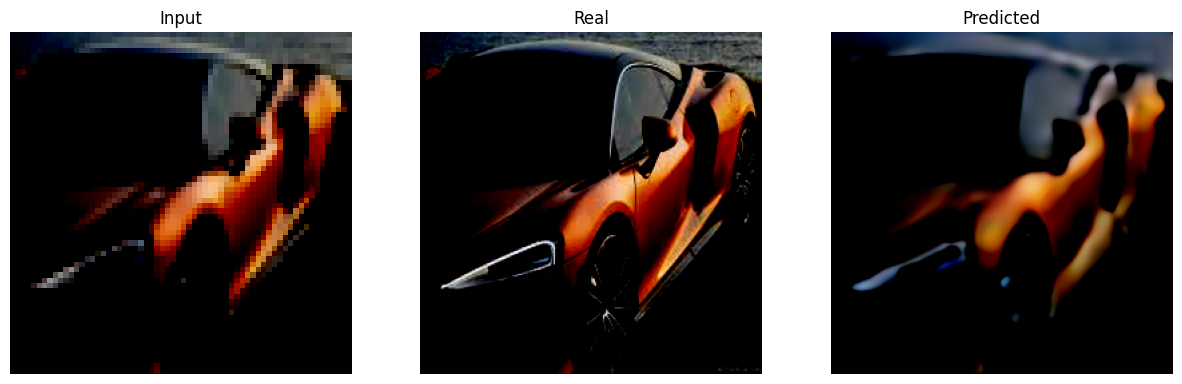

-----------------------------------------------------------
| End of epoch  71 | Time: 54.91s | Train psnr   21.702 | Train Loss    0.107 | Valid psnr   21.171 | Valid Loss    0.109 
-----------------------------------------------------------
| Epoch  72 |    50/   86 batches | Psnr   21.638
-----------------------------------------------------------
| End of epoch  72 | Time: 54.31s | Train psnr   21.441 | Train Loss    0.107 | Valid psnr   20.628 | Valid Loss    0.124 
-----------------------------------------------------------
| Epoch  73 |    50/   86 batches | Psnr   21.639
-----------------------------------------------------------
| End of epoch  73 | Time: 54.29s | Train psnr   21.452 | Train Loss    0.107 | Valid psnr   21.059 | Valid Loss    0.114 
-----------------------------------------------------------
| Epoch  74 |    50/   86 batches | Psnr   21.447


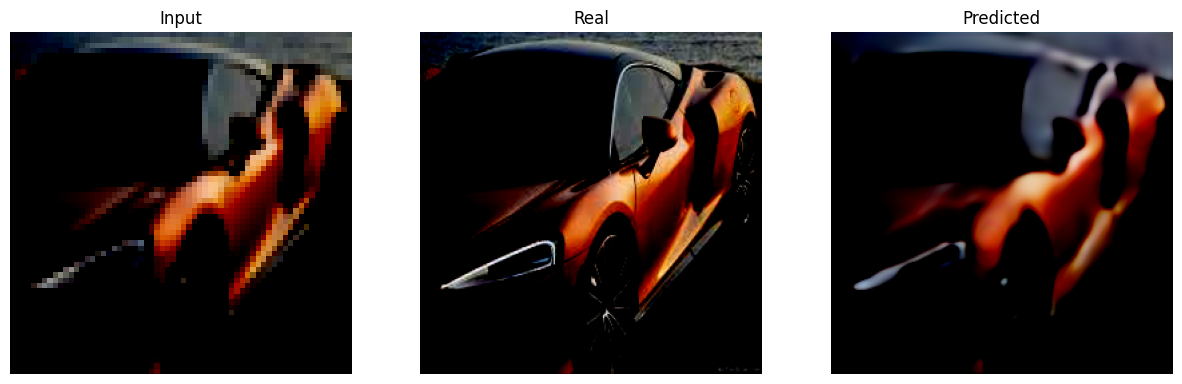

-----------------------------------------------------------
| End of epoch  74 | Time: 55.17s | Train psnr   21.542 | Train Loss    0.109 | Valid psnr   21.430 | Valid Loss    0.110 
-----------------------------------------------------------
| Epoch  75 |    50/   86 batches | Psnr   21.752
-----------------------------------------------------------
| End of epoch  75 | Time: 54.38s | Train psnr   21.395 | Train Loss    0.107 | Valid psnr   20.980 | Valid Loss    0.117 
-----------------------------------------------------------
| Epoch  76 |    50/   86 batches | Psnr   21.802
-----------------------------------------------------------
| End of epoch  76 | Time: 54.17s | Train psnr   21.542 | Train Loss    0.105 | Valid psnr   21.098 | Valid Loss    0.111 
-----------------------------------------------------------
| Epoch  77 |    50/   86 batches | Psnr   21.658
-----------------------------------------------------------
| End of epoch  77 | Time: 54.22s | Train psnr   21.705 | Tra

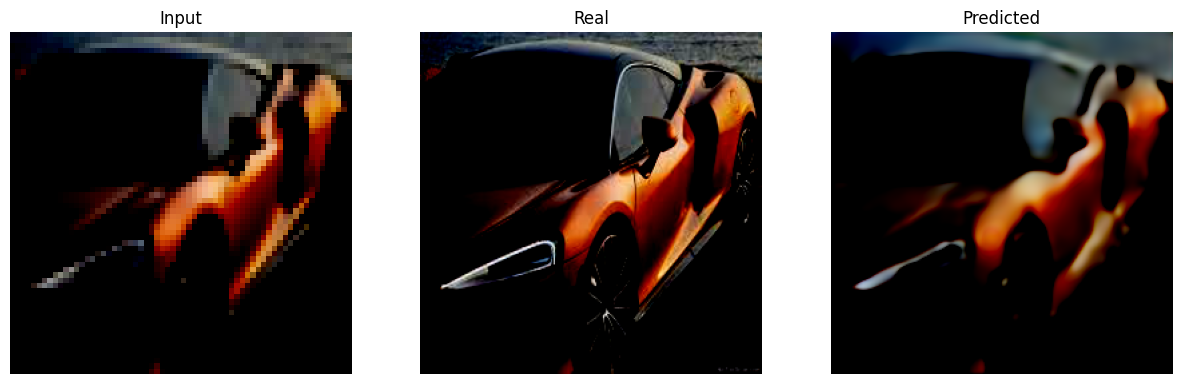

-----------------------------------------------------------
| End of epoch  81 | Time: 55.03s | Train psnr   21.815 | Train Loss    0.103 | Valid psnr   21.454 | Valid Loss    0.107 
-----------------------------------------------------------
| Epoch  82 |    50/   86 batches | Psnr   21.815
-----------------------------------------------------------
| End of epoch  82 | Time: 54.21s | Train psnr   21.651 | Train Loss    0.105 | Valid psnr   20.829 | Valid Loss    0.124 
-----------------------------------------------------------
| Epoch  83 |    50/   86 batches | Psnr   21.709


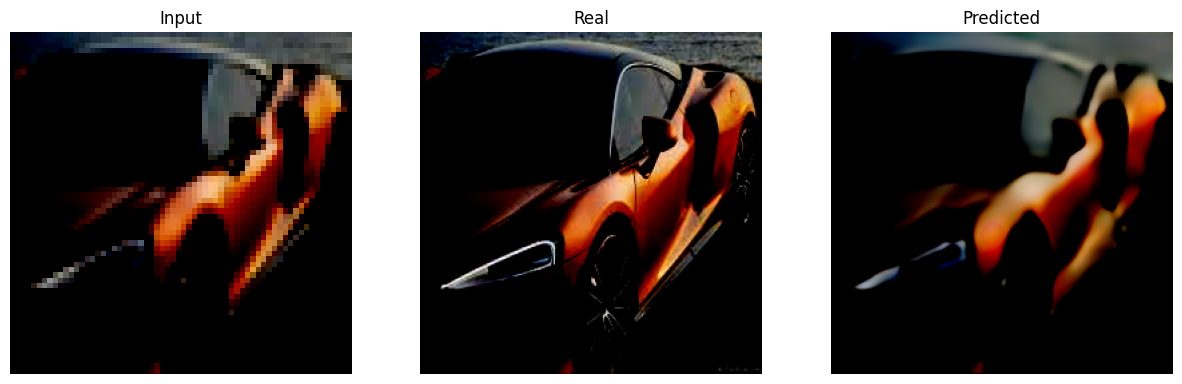

-----------------------------------------------------------
| End of epoch  83 | Time: 55.27s | Train psnr   22.210 | Train Loss    0.102 | Valid psnr   21.560 | Valid Loss    0.104 
-----------------------------------------------------------
| Epoch  84 |    50/   86 batches | Psnr   21.798
-----------------------------------------------------------
| End of epoch  84 | Time: 54.42s | Train psnr   22.095 | Train Loss    0.102 | Valid psnr   21.328 | Valid Loss    0.113 
-----------------------------------------------------------
| Epoch  85 |    50/   86 batches | Psnr   22.021
-----------------------------------------------------------
| End of epoch  85 | Time: 54.26s | Train psnr   21.789 | Train Loss    0.102 | Valid psnr   20.413 | Valid Loss    0.124 
-----------------------------------------------------------
| Epoch  86 |    50/   86 batches | Psnr   22.012
-----------------------------------------------------------
| End of epoch  86 | Time: 54.23s | Train psnr   21.792 | Tra

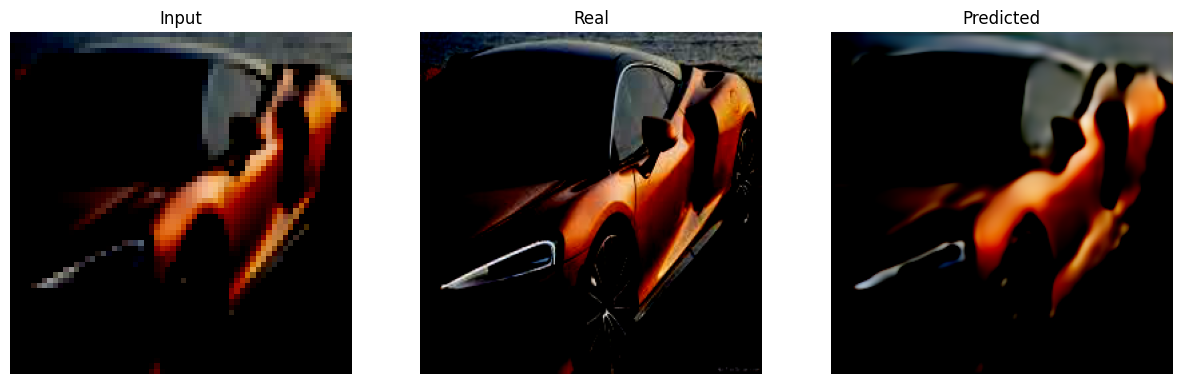

-----------------------------------------------------------
| End of epoch  91 | Time: 54.99s | Train psnr   21.546 | Train Loss    0.104 | Valid psnr   21.592 | Valid Loss    0.104 
-----------------------------------------------------------
| Epoch  92 |    50/   86 batches | Psnr   21.887
-----------------------------------------------------------
| End of epoch  92 | Time: 54.15s | Train psnr   21.912 | Train Loss    0.104 | Valid psnr   21.081 | Valid Loss    0.111 
-----------------------------------------------------------
| Epoch  93 |    50/   86 batches | Psnr   22.039
-----------------------------------------------------------
| End of epoch  93 | Time: 54.33s | Train psnr   22.075 | Train Loss    0.100 | Valid psnr   21.407 | Valid Loss    0.113 
-----------------------------------------------------------
| Epoch  94 |    50/   86 batches | Psnr   22.069
-----------------------------------------------------------
| End of epoch  94 | Time: 54.40s | Train psnr   21.967 | Tra

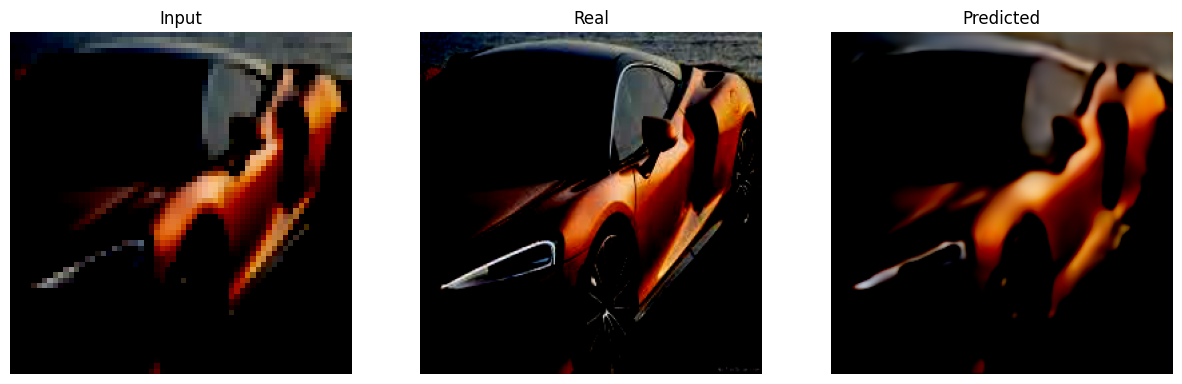

-----------------------------------------------------------
| End of epoch  98 | Time: 55.16s | Train psnr   22.121 | Train Loss    0.098 | Valid psnr   21.640 | Valid Loss    0.103 
-----------------------------------------------------------
| Epoch  99 |    50/   86 batches | Psnr   22.150
-----------------------------------------------------------
| End of epoch  99 | Time: 54.42s | Train psnr   22.097 | Train Loss    0.100 | Valid psnr   21.624 | Valid Loss    0.107 
-----------------------------------------------------------
| Epoch 100 |    50/   86 batches | Psnr   22.234


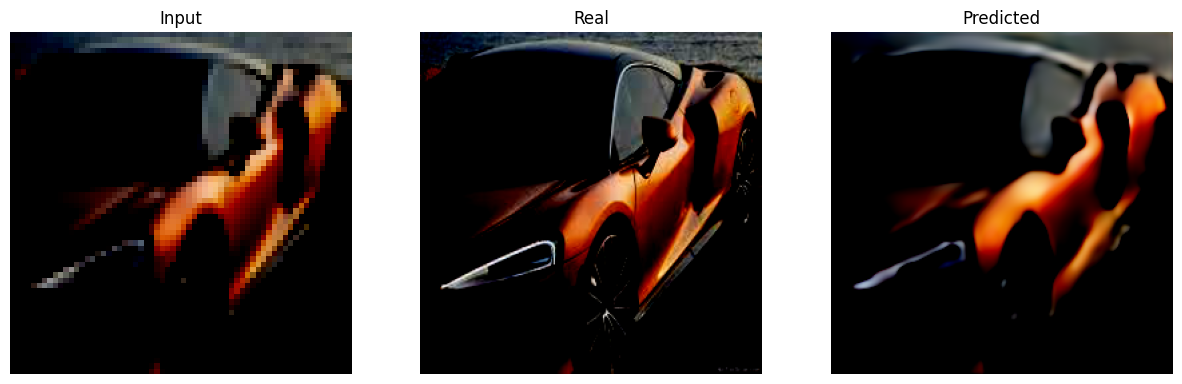

-----------------------------------------------------------
| End of epoch 100 | Time: 54.90s | Train psnr   22.128 | Train Loss    0.099 | Valid psnr   21.664 | Valid Loss    0.105 
-----------------------------------------------------------


In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SR_unet_model_noskip = SR_Unet_NoSkip().to(device)
SR_unet_model_noskip.to(device)

criterion = nn.L1Loss()

optimizer = optim.Adam(SR_unet_model_noskip.parameters(), lr=1e-4, betas=[0.5,0.999])

save_model = './UNET'
os.makedirs(save_model, exist_ok = True)

EPOCHS = 100
SR_unet_model_noskip, metrics = train(
    SR_unet_model_noskip, 'SR_unet_model_noskip', save_model, optimizer, criterion, train_loader, test_loader, EPOCHS, device
)

In [ ]:
plot_result(
    EPOCHS,
    metrics["train_psnr"],
    metrics["valid_psnr"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [ ]:
test_psnr, test_loss = evaluate_epoch(SR_unet_model_noskip, criterion, test_loader, device)
test_psnr, test_loss

In [ ]:
predict_and_display(SR_unet_model_noskip, train_loader, device)

In [ ]:
predict_and_display(SR_unet_model_noskip, test_loader, device)

### UNet with skip connection

| Epoch   1 |    50/   86 batches | Psnr    9.476


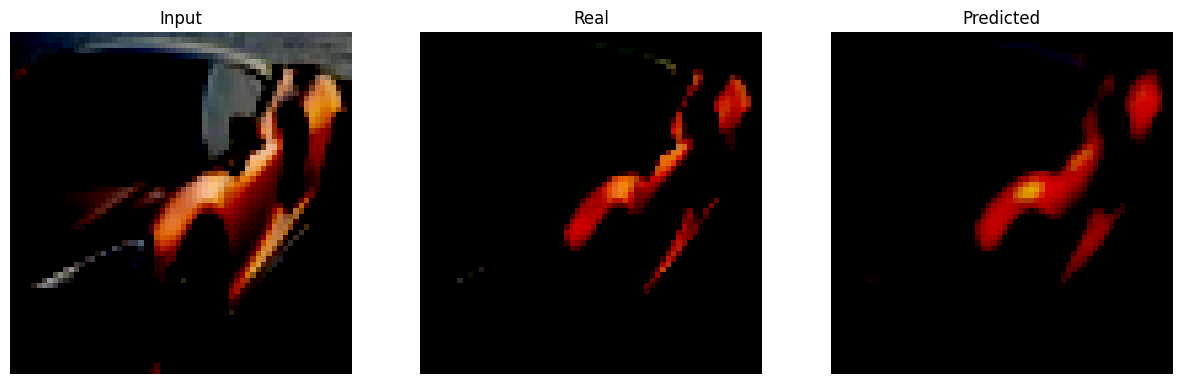

-----------------------------------------------------------
| End of epoch   1 | Time: 10.35s | Train psnr   10.654 | Train Loss    1.069 | Valid psnr   10.728 | Valid Loss    0.944 
-----------------------------------------------------------
| Epoch   2 |    50/   86 batches | Psnr   10.492


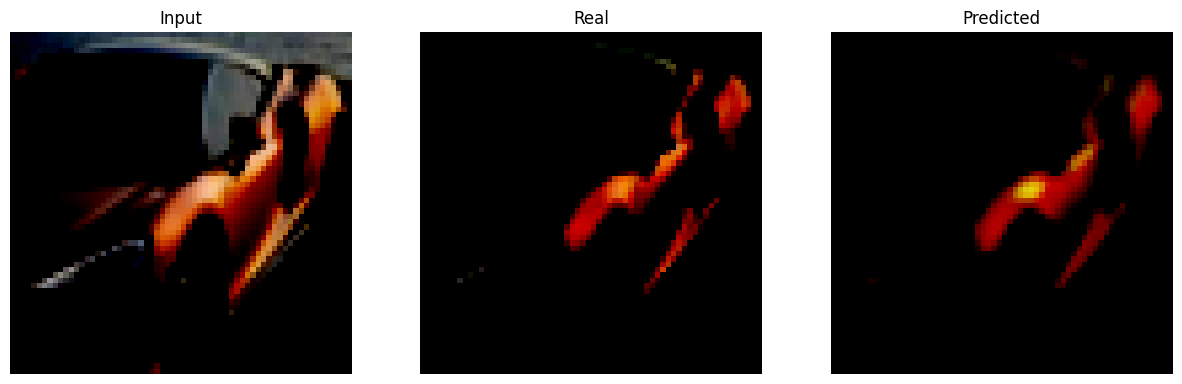

-----------------------------------------------------------
| End of epoch   2 | Time: 10.86s | Train psnr   11.481 | Train Loss    0.931 | Valid psnr   11.057 | Valid Loss    0.896 
-----------------------------------------------------------
| Epoch   3 |    50/   86 batches | Psnr   11.270


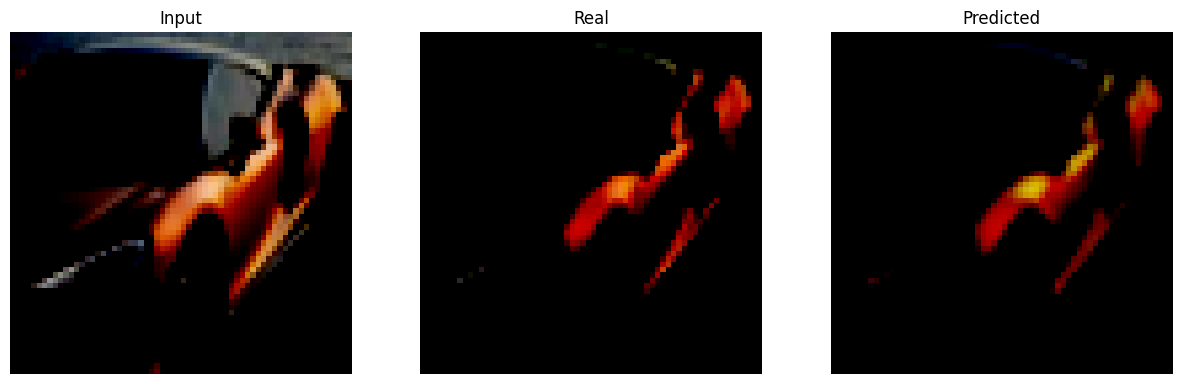

-----------------------------------------------------------
| End of epoch   3 | Time: 10.26s | Train psnr   11.584 | Train Loss    0.867 | Valid psnr   11.454 | Valid Loss    0.839 
-----------------------------------------------------------
| Epoch   4 |    50/   86 batches | Psnr   11.752


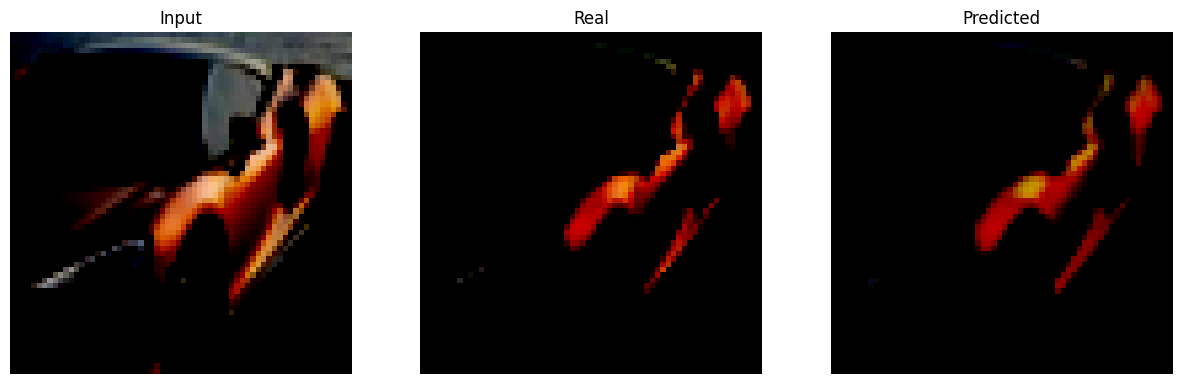

-----------------------------------------------------------
| End of epoch   4 | Time: 10.12s | Train psnr   11.721 | Train Loss    0.815 | Valid psnr   11.814 | Valid Loss    0.796 
-----------------------------------------------------------
| Epoch   5 |    50/   86 batches | Psnr   12.077


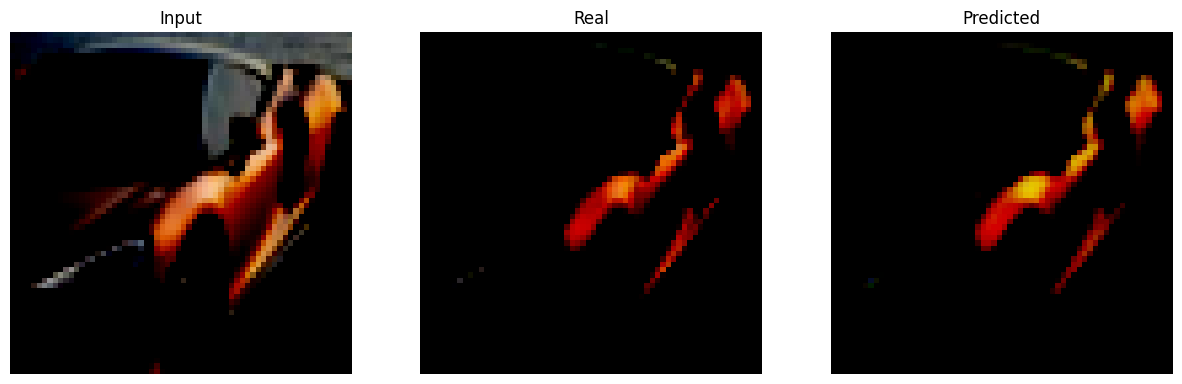

-----------------------------------------------------------
| End of epoch   5 | Time: 10.08s | Train psnr   11.855 | Train Loss    0.781 | Valid psnr   11.919 | Valid Loss    0.776 
-----------------------------------------------------------
| Epoch   6 |    50/   86 batches | Psnr   12.376


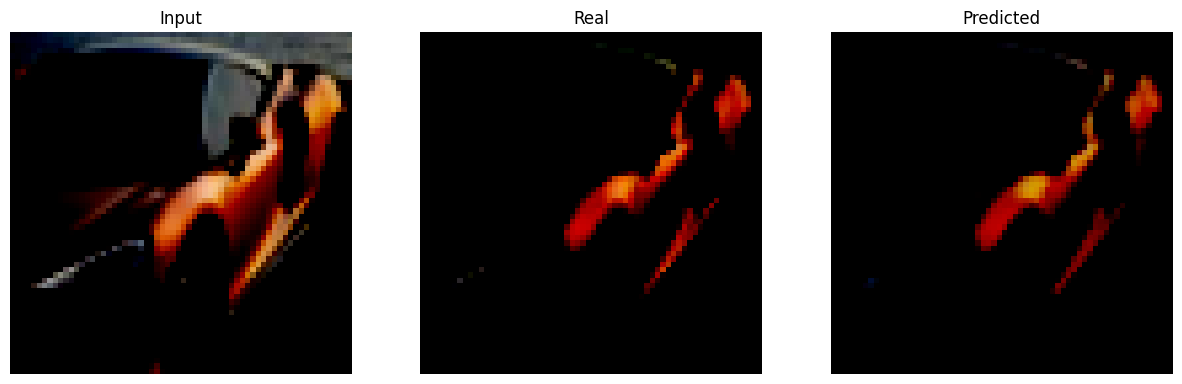

-----------------------------------------------------------
| End of epoch   6 | Time: 10.17s | Train psnr   11.886 | Train Loss    0.758 | Valid psnr   12.121 | Valid Loss    0.747 
-----------------------------------------------------------
| Epoch   7 |    50/   86 batches | Psnr   12.512


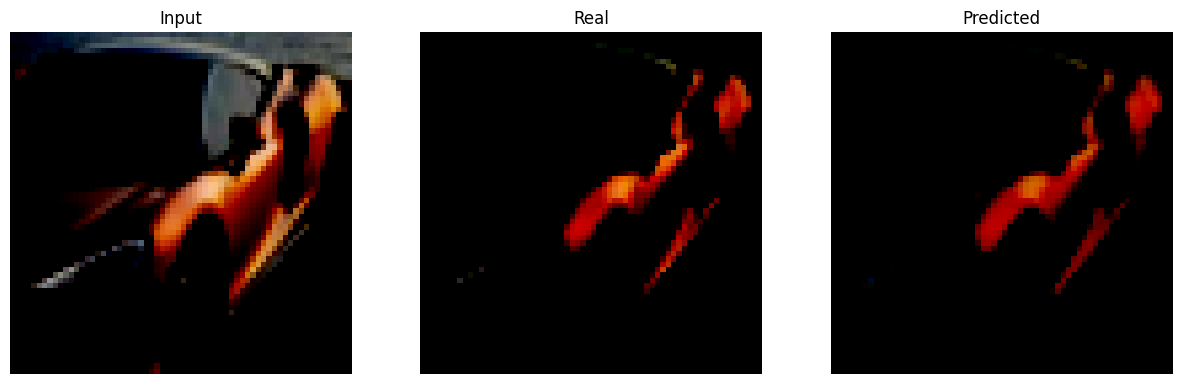

-----------------------------------------------------------
| End of epoch   7 | Time: 10.17s | Train psnr   12.055 | Train Loss    0.742 | Valid psnr   12.310 | Valid Loss    0.732 
-----------------------------------------------------------
| Epoch   8 |    50/   86 batches | Psnr   12.698


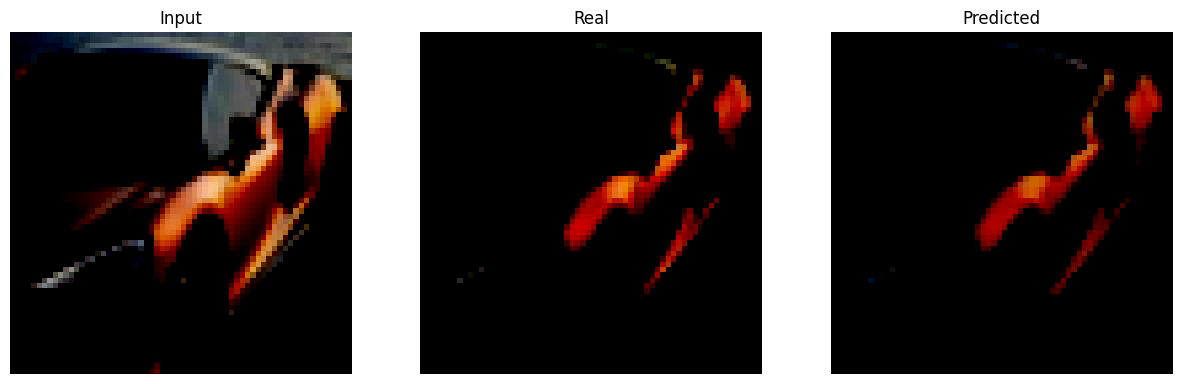

-----------------------------------------------------------
| End of epoch   8 | Time: 10.43s | Train psnr   12.023 | Train Loss    0.729 | Valid psnr   12.358 | Valid Loss    0.724 
-----------------------------------------------------------
| Epoch   9 |    50/   86 batches | Psnr   12.424


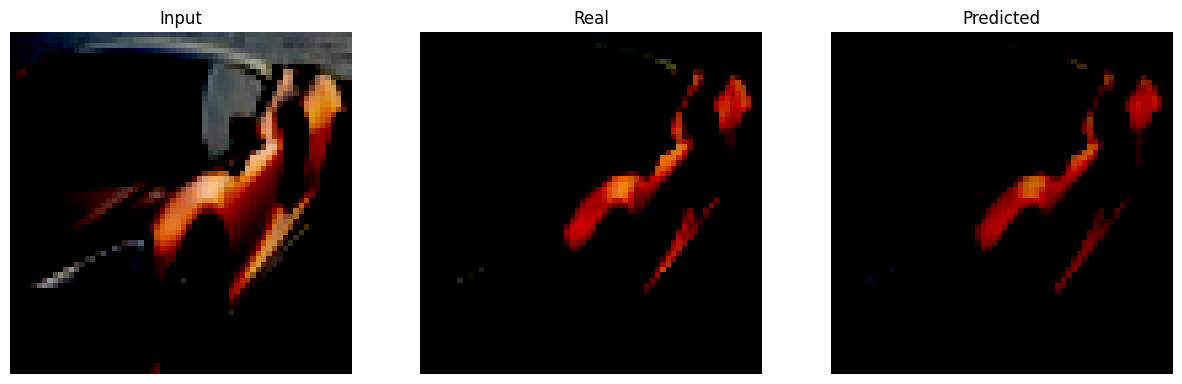

-----------------------------------------------------------
| End of epoch   9 | Time:  9.82s | Train psnr   12.721 | Train Loss    0.712 | Valid psnr   12.553 | Valid Loss    0.704 
-----------------------------------------------------------
| Epoch  10 |    50/   86 batches | Psnr   12.467


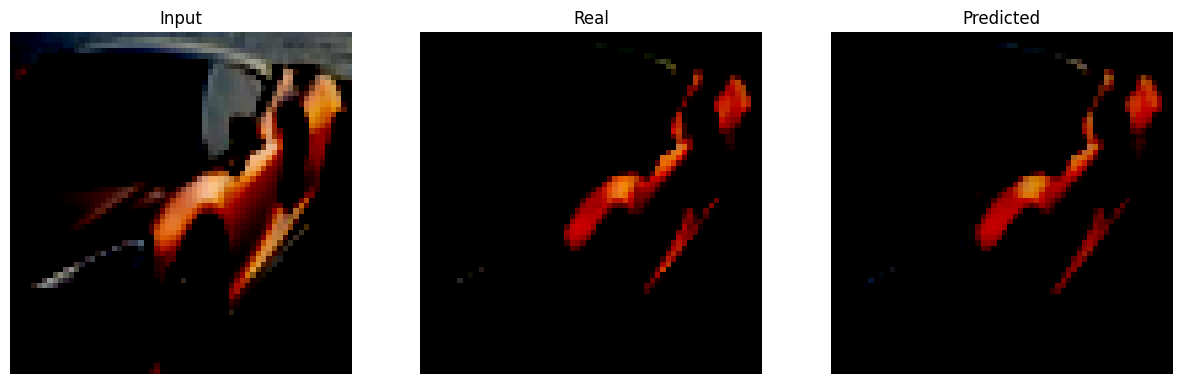

-----------------------------------------------------------
| End of epoch  10 | Time: 10.16s | Train psnr   12.751 | Train Loss    0.708 | Valid psnr   12.566 | Valid Loss    0.697 
-----------------------------------------------------------
| Epoch  11 |    50/   86 batches | Psnr   12.584
-----------------------------------------------------------
| End of epoch  11 | Time:  9.62s | Train psnr   12.637 | Train Loss    0.699 | Valid psnr   12.561 | Valid Loss    0.697 
-----------------------------------------------------------
| Epoch  12 |    50/   86 batches | Psnr   12.947


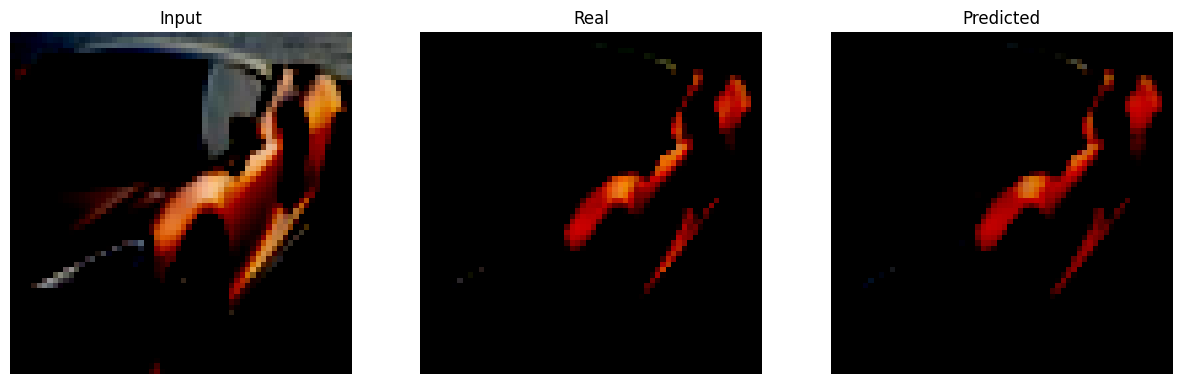

-----------------------------------------------------------
| End of epoch  12 | Time: 10.68s | Train psnr   12.317 | Train Loss    0.694 | Valid psnr   12.586 | Valid Loss    0.695 
-----------------------------------------------------------
| Epoch  13 |    50/   86 batches | Psnr   12.704


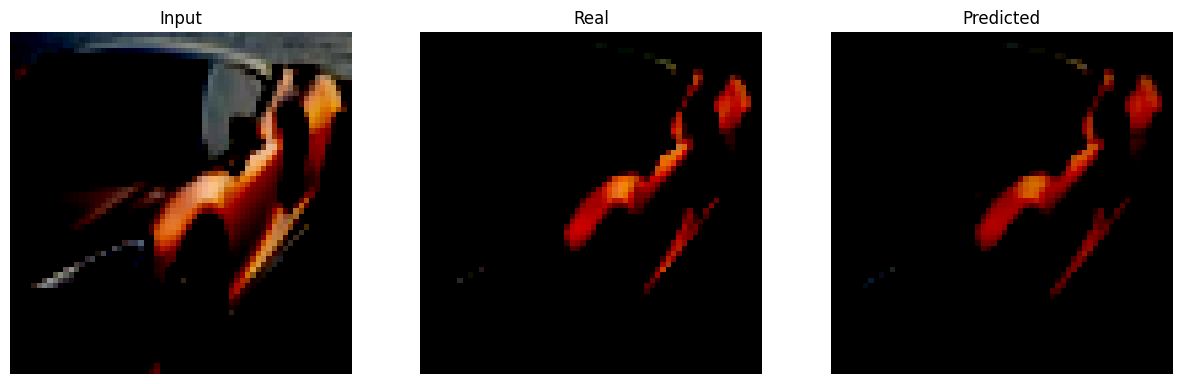

-----------------------------------------------------------
| End of epoch  13 | Time:  9.96s | Train psnr   12.681 | Train Loss    0.691 | Valid psnr   12.667 | Valid Loss    0.687 
-----------------------------------------------------------
| Epoch  14 |    50/   86 batches | Psnr   12.864
-----------------------------------------------------------
| End of epoch  14 | Time:  9.61s | Train psnr   12.484 | Train Loss    0.689 | Valid psnr   12.608 | Valid Loss    0.694 
-----------------------------------------------------------
| Epoch  15 |    50/   86 batches | Psnr   13.015
-----------------------------------------------------------
| End of epoch  15 | Time:  9.60s | Train psnr   12.480 | Train Loss    0.685 | Valid psnr   12.637 | Valid Loss    0.689 
-----------------------------------------------------------
| Epoch  16 |    50/   86 batches | Psnr   12.823


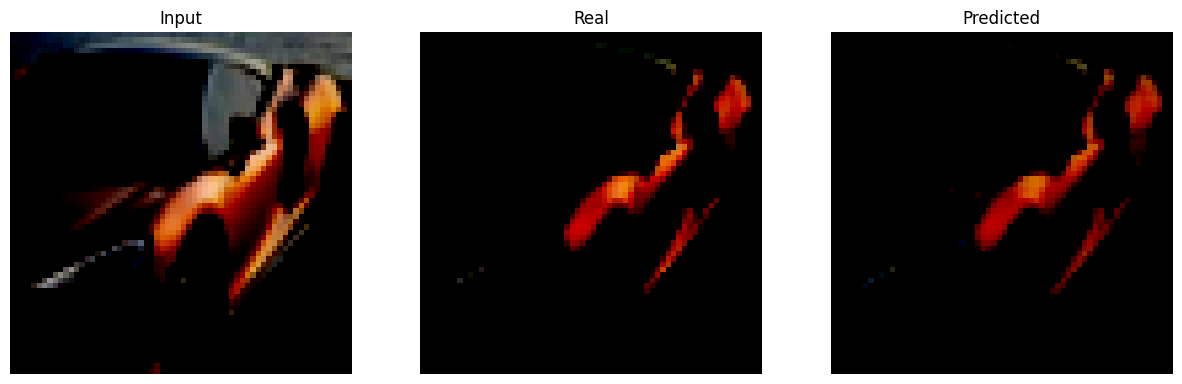

-----------------------------------------------------------
| End of epoch  16 | Time: 10.50s | Train psnr   12.665 | Train Loss    0.682 | Valid psnr   12.699 | Valid Loss    0.686 
-----------------------------------------------------------
| Epoch  17 |    50/   86 batches | Psnr   12.846
-----------------------------------------------------------
| End of epoch  17 | Time:  9.44s | Train psnr   12.562 | Train Loss    0.684 | Valid psnr   12.680 | Valid Loss    0.684 
-----------------------------------------------------------
| Epoch  18 |    50/   86 batches | Psnr   12.692
-----------------------------------------------------------
| End of epoch  18 | Time:  9.61s | Train psnr   12.873 | Train Loss    0.679 | Valid psnr   12.695 | Valid Loss    0.685 
-----------------------------------------------------------
| Epoch  19 |    50/   86 batches | Psnr   12.676


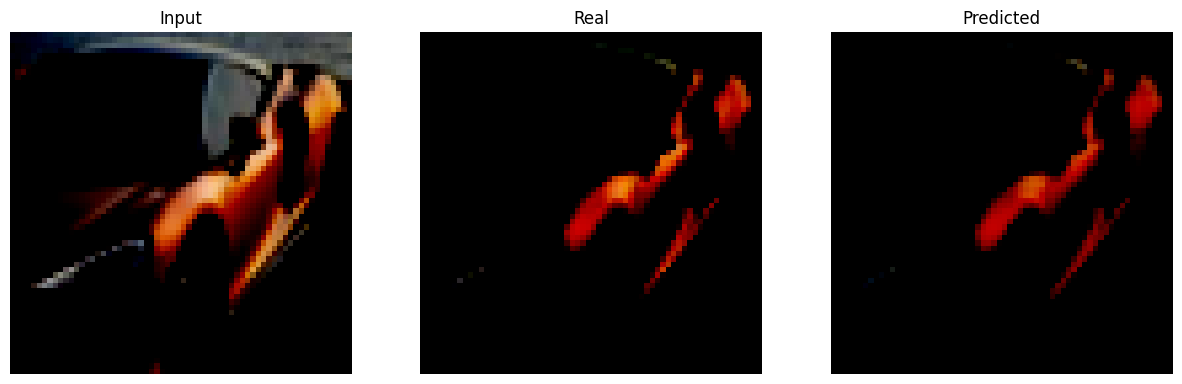

-----------------------------------------------------------
| End of epoch  19 | Time: 10.20s | Train psnr   12.959 | Train Loss    0.676 | Valid psnr   12.734 | Valid Loss    0.679 
-----------------------------------------------------------
| Epoch  20 |    50/   86 batches | Psnr   12.789


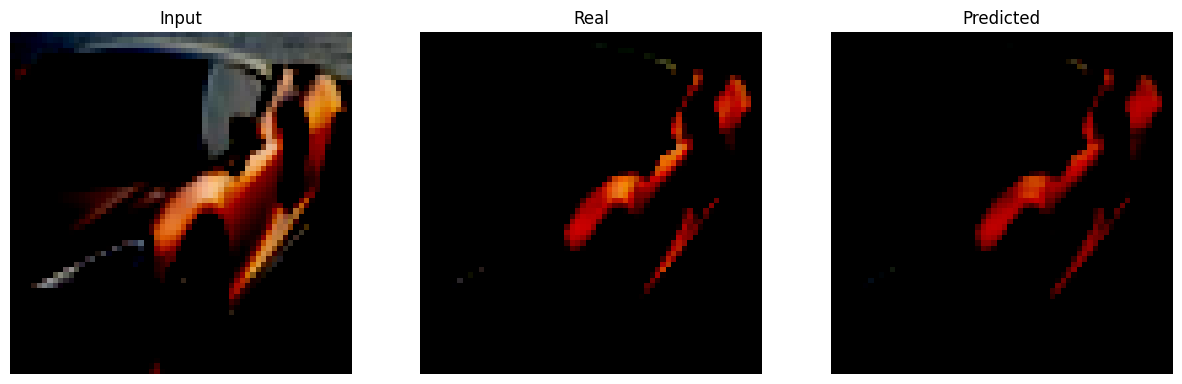

-----------------------------------------------------------
| End of epoch  20 | Time: 10.23s | Train psnr   12.863 | Train Loss    0.674 | Valid psnr   12.761 | Valid Loss    0.680 
-----------------------------------------------------------
| Epoch  21 |    50/   86 batches | Psnr   13.146
-----------------------------------------------------------
| End of epoch  21 | Time:  9.61s | Train psnr   12.438 | Train Loss    0.676 | Valid psnr   12.727 | Valid Loss    0.679 
-----------------------------------------------------------
| Epoch  22 |    50/   86 batches | Psnr   12.792
-----------------------------------------------------------
| End of epoch  22 | Time:  9.57s | Train psnr   12.836 | Train Loss    0.675 | Valid psnr   12.729 | Valid Loss    0.683 
-----------------------------------------------------------
| Epoch  23 |    50/   86 batches | Psnr   12.838


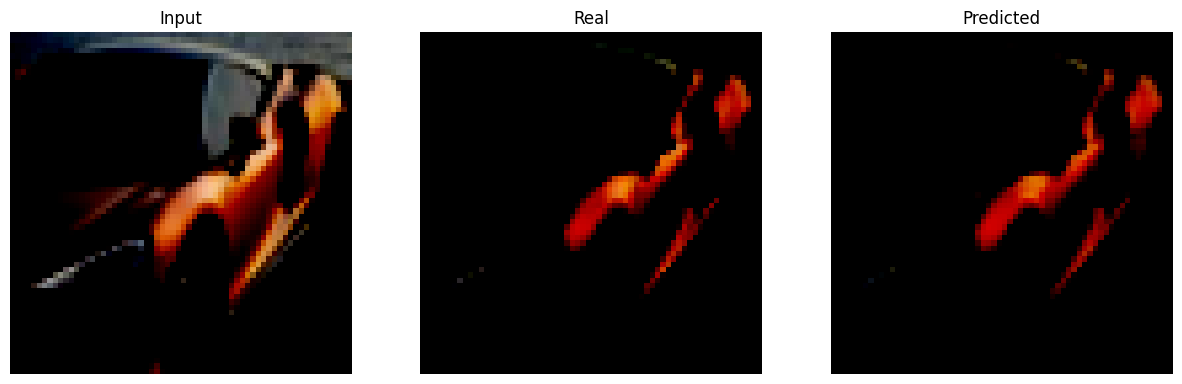

-----------------------------------------------------------
| End of epoch  23 | Time: 10.23s | Train psnr   12.793 | Train Loss    0.670 | Valid psnr   12.769 | Valid Loss    0.675 
-----------------------------------------------------------
| Epoch  24 |    50/   86 batches | Psnr   12.851
-----------------------------------------------------------
| End of epoch  24 | Time:  9.71s | Train psnr   12.740 | Train Loss    0.672 | Valid psnr   12.764 | Valid Loss    0.670 
-----------------------------------------------------------
| Epoch  25 |    50/   86 batches | Psnr   13.040
-----------------------------------------------------------
| End of epoch  25 | Time:  9.46s | Train psnr   12.691 | Train Loss    0.672 | Valid psnr   12.760 | Valid Loss    0.675 
-----------------------------------------------------------
| Epoch  26 |    50/   86 batches | Psnr   12.863
-----------------------------------------------------------
| End of epoch  26 | Time:  9.53s | Train psnr   12.827 | Tra

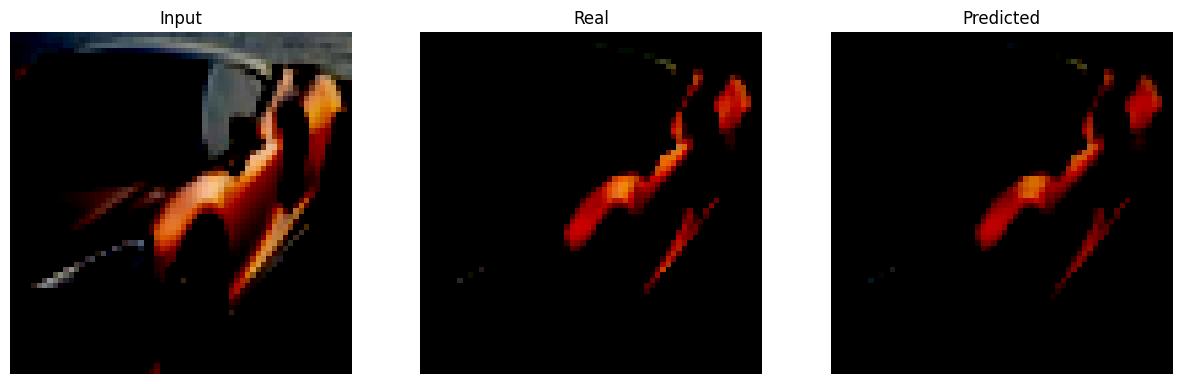

-----------------------------------------------------------
| End of epoch  27 | Time: 10.22s | Train psnr   12.730 | Train Loss    0.667 | Valid psnr   12.770 | Valid Loss    0.672 
-----------------------------------------------------------
| Epoch  28 |    50/   86 batches | Psnr   12.812
-----------------------------------------------------------
| End of epoch  28 | Time:  9.69s | Train psnr   12.846 | Train Loss    0.671 | Valid psnr   12.755 | Valid Loss    0.672 
-----------------------------------------------------------
| Epoch  29 |    50/   86 batches | Psnr   12.765
-----------------------------------------------------------
| End of epoch  29 | Time:  9.49s | Train psnr   12.913 | Train Loss    0.668 | Valid psnr   12.719 | Valid Loss    0.681 
-----------------------------------------------------------
| Epoch  30 |    50/   86 batches | Psnr   12.801


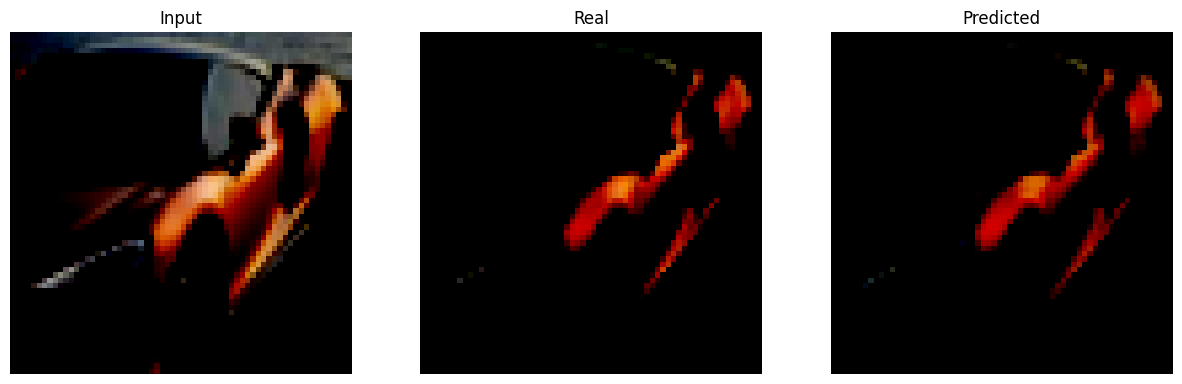

-----------------------------------------------------------
| End of epoch  30 | Time: 10.07s | Train psnr   12.859 | Train Loss    0.671 | Valid psnr   12.772 | Valid Loss    0.673 
-----------------------------------------------------------
| Epoch  31 |    50/   86 batches | Psnr   12.777
-----------------------------------------------------------
| End of epoch  31 | Time:  9.70s | Train psnr   13.096 | Train Loss    0.666 | Valid psnr   12.767 | Valid Loss    0.668 
-----------------------------------------------------------
| Epoch  32 |    50/   86 batches | Psnr   12.833


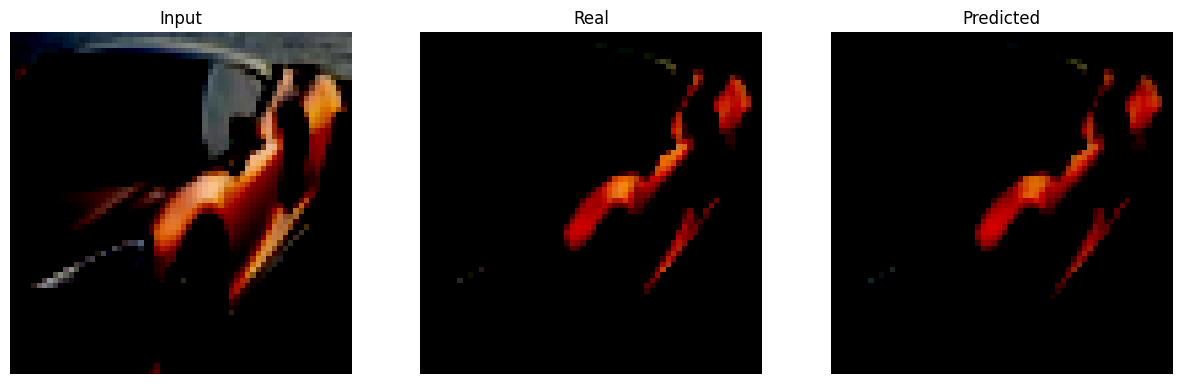

-----------------------------------------------------------
| End of epoch  32 | Time: 10.22s | Train psnr   12.947 | Train Loss    0.665 | Valid psnr   12.779 | Valid Loss    0.670 
-----------------------------------------------------------
| Epoch  33 |    50/   86 batches | Psnr   12.693
-----------------------------------------------------------
| End of epoch  33 | Time:  9.46s | Train psnr   13.117 | Train Loss    0.666 | Valid psnr   12.774 | Valid Loss    0.668 
-----------------------------------------------------------
| Epoch  34 |    50/   86 batches | Psnr   12.916
-----------------------------------------------------------
| End of epoch  34 | Time:  9.50s | Train psnr   12.753 | Train Loss    0.665 | Valid psnr   12.773 | Valid Loss    0.674 
-----------------------------------------------------------
| Epoch  35 |    50/   86 batches | Psnr   12.990


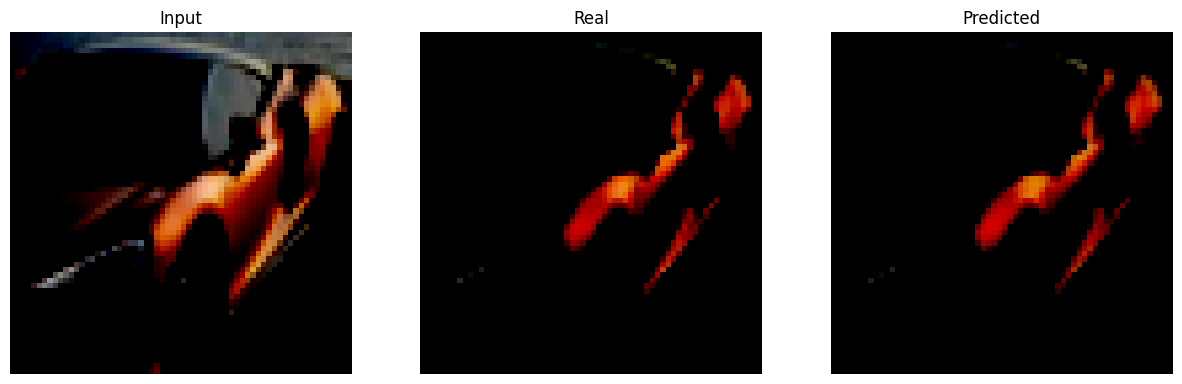

-----------------------------------------------------------
| End of epoch  35 | Time: 10.21s | Train psnr   12.625 | Train Loss    0.667 | Valid psnr   12.790 | Valid Loss    0.666 
-----------------------------------------------------------
| Epoch  36 |    50/   86 batches | Psnr   12.772
-----------------------------------------------------------
| End of epoch  36 | Time:  9.66s | Train psnr   13.012 | Train Loss    0.665 | Valid psnr   12.779 | Valid Loss    0.671 
-----------------------------------------------------------
| Epoch  37 |    50/   86 batches | Psnr   12.810
-----------------------------------------------------------
| End of epoch  37 | Time: 12.54s | Train psnr   12.828 | Train Loss    0.662 | Valid psnr   12.783 | Valid Loss    0.668 
-----------------------------------------------------------
| Epoch  38 |    50/   86 batches | Psnr   12.829


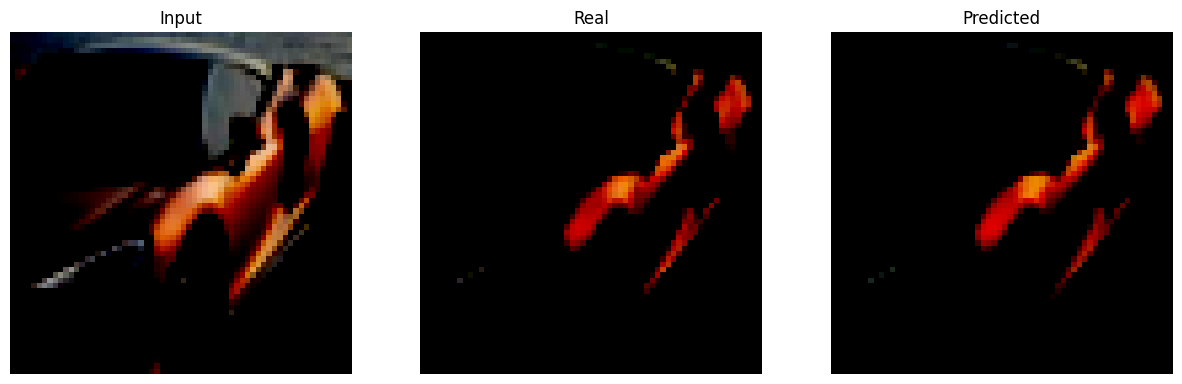

-----------------------------------------------------------
| End of epoch  38 | Time: 10.28s | Train psnr   12.957 | Train Loss    0.664 | Valid psnr   12.793 | Valid Loss    0.665 
-----------------------------------------------------------
| Epoch  39 |    50/   86 batches | Psnr   12.720
-----------------------------------------------------------
| End of epoch  39 | Time:  9.61s | Train psnr   13.077 | Train Loss    0.660 | Valid psnr   12.792 | Valid Loss    0.668 
-----------------------------------------------------------
| Epoch  40 |    50/   86 batches | Psnr   12.853


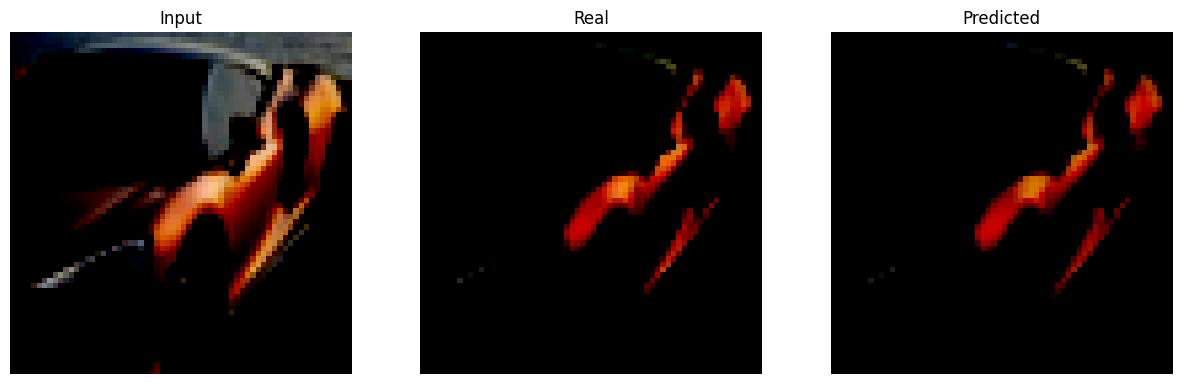

-----------------------------------------------------------
| End of epoch  40 | Time: 10.20s | Train psnr   12.931 | Train Loss    0.661 | Valid psnr   12.802 | Valid Loss    0.665 
-----------------------------------------------------------
| Epoch  41 |    50/   86 batches | Psnr   12.840


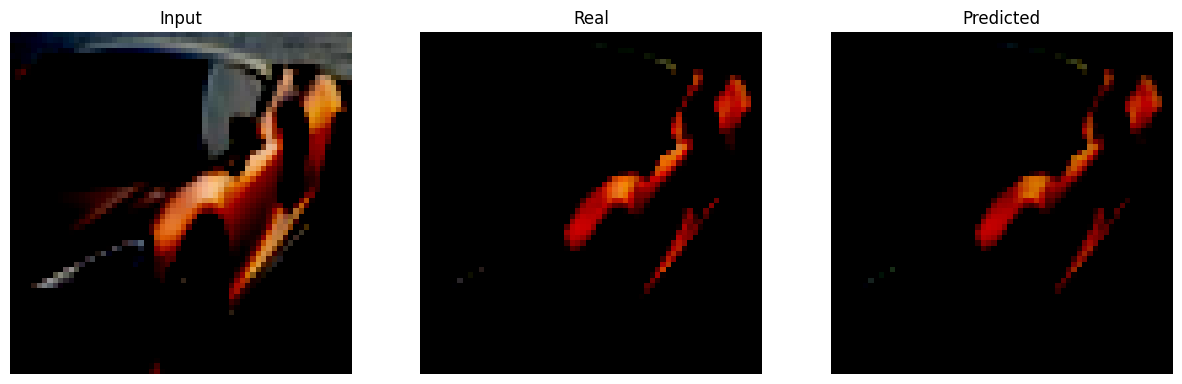

-----------------------------------------------------------
| End of epoch  41 | Time: 10.28s | Train psnr   13.003 | Train Loss    0.663 | Valid psnr   12.804 | Valid Loss    0.666 
-----------------------------------------------------------
| Epoch  42 |    50/   86 batches | Psnr   12.801
-----------------------------------------------------------
| End of epoch  42 | Time:  9.34s | Train psnr   13.070 | Train Loss    0.660 | Valid psnr   12.793 | Valid Loss    0.672 
-----------------------------------------------------------


KeyboardInterrupt: 

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SR_unet_model = SR_Unet().to(device)
SR_unet_model.to(device)

criterion = nn.L1Loss()

optimizer = optim.Adam(SR_unet_model.parameters(), lr=1e-4, betas=[0.5,0.999])

save_model = './UNET'
os.makedirs(save_model, exist_ok = True)

EPOCHS = 100
SR_unet_model, metrics = train(
    SR_unet_model, 'SR_unet_model', save_model, optimizer, criterion, train_loader, test_loader, EPOCHS, device
)

In [ ]:
plot_result(
    EPOCHS,
    metrics["train_psnr"],
    metrics["valid_psnr"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [ ]:
test_psnr, test_loss = evaluate_epoch(SR_unet_model, criterion, test_loader, device)
test_psnr, test_loss

In [ ]:
predict_and_display(SR_unet_model, train_loader, device)

In [ ]:
predict_and_display(SR_unet_model, test_loader, device)

# Impainting Image with UNet

We are using the same model in Super Resolution, only inputs and labels are changed to fit with the problem. These changes are adapted from our custom class ImageDataset.

In [ ]:
LHR_TRAIN_DATA_PATH = '/content/Khoa_LHR_image/train'
LHR_VAL_DATA_PATH = '/content/Khoa_LHR_image/val'
BATCH_SIZE = 8
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [ ]:
import cv2

class ImageDataset(Dataset):
    def __init__(self, img_dir, is_train=True):
        self.is_train = is_train
        self.img_dir = img_dir
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def normalize(self, input_image, target_image):
        input_image = input_image*2 - 1
        target_image = input_image*2 - 1

        return input_image, target_image

    def random_jitter(self, input_image, target_image):
        if torch.rand([]) < 0.5:
            input_image = transforms.functional.hflip(input_image)
            target_image = transforms.functional.hflip(target_image)

        return input_image, target_image

    def create_mask(self, image):
        masked_image = image.copy()
        ## Prepare masking matrix
        mask = np.full((IMG_WIDTH,IMG_HEIGHT,3), 0, np.uint8)
        for _ in range(np.random.randint(1, 5)):
            # Get random x locations to start line
            x1, x2 = np.random.randint(1, IMG_WIDTH), np.random.randint(1, IMG_WIDTH)
            # Get random y locations to start line
            y1, y2 = np.random.randint(1, IMG_HEIGHT), np.random.randint(1, IMG_HEIGHT)
            # Get random thickness of the line drawn
            thickness = np.random.randint(1, 15)
            # Draw line on the black mask
            cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)
        masked_image = np.where(mask, 255*np.ones_like(mask), masked_image)
        return masked_image

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = np.array(Image.open(img_path).convert('RGB'))

        input_image = self.create_mask(image)
        input_image = transforms.functional.to_tensor(input_image)
        target_image = transforms.functional.to_tensor(image)

        input_image, target_image = self.normalize(input_image, target_image)
        if self.is_train:
            input_image, target_image = self.random_jitter(input_image, target_image)

        return input_image, target_image